# **Forecasting Sales for a Business/Store (Rossmann)**


In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import datetime #Convert to unix time
import time #Convert to unix time
import numpy as np #Do aritmetic operations on arrays
import matplotlib # matplotlib: used to plot graphs
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams  #Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans #Clustering
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
from numpy import mean
import math
import pickle
import os
from datetime import datetime
from time import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.manifold import TSNE
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold # for regression prob, RepeatedStratifieKFold for Classification
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

# **Data Information**

<p>
Ge the data from : https://www.kaggle.com/competitions/rossmann-store-sales/data (2015 data).
Kaggle was provided with historical sales data for 1,115 Rossmann stores. The Data is collected between 01st Jan, 2013 to 31st Jul, 2015. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
</p>

### Data:


<p> train - historical data including Sales </p>
<p> test - historical data excluding Sales </p>
<p> store - supplemental information about the stores</p>


### Data fields:


<p> <b>Id</b> - an Id that represents a (Store, Date) duple within the test set </p>
<p> <b>Date</b> - Date on which Sales made for a corresponding Store </p>
<p> <b>DayOfWeek</b> - 0 to 6 (Sun to Sat) based on Date </p>
<p> <b>Store</b> - a unique Id for each store </p>
<p> <b>Sales</b> - the turnover for any given day (this is what you are predicting) </p>
<p> <b>Customers</b> - the number of customers on a given day </p>
<p> <b>Open</b> - an indicator for whether the store was open: 0 = closed, 1 = open </p>
<p> <b>StateHoliday</b> - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None </p>
<p> <b>SchoolHoliday</b> - indicates if the (Store, Date) was affected by the closure of public schools </p>
<p> <b>StoreType</b> - differentiates between 4 different store models: a, b, c, d </p>
<p> <b>Assortment</b> - describes an assortment level: a = basic, b = extra, c = extended </p>
<p> <b>CompetitionDistance</b> - distance in meters to the nearest competitor store </p>
<p> <b>CompetitionOpenSince[Month/Year]</b> - gives the approximate year and month of the time the nearest competitor was opened </p>
<p> <b>Promo</b> - indicates whether a store is running a promo on that day </p>
<p> <b>Promo2</b> - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating </p>
<p> <b>Promo2Since[Year/Week]</b> - describes the year and calendar week when the store started participating in Promo2 </p>
<p> <b>PromoInterval</b> - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store </p>

In [ ]:
# Verifying your notebook is running on GPU, if GPU utilized output is /device:GPU:0
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


### Steps to download file from kaggle

In [ ]:
#make sure kaggle.json file is present
!ls -lha kaggle.json

-rw-r--r-- 1 root root 74 Jan  9 06:03 kaggle.json


In [ ]:
#Install kaggle API client
!pip install -q kaggle

In [ ]:
#kaggle API client expects the file to be in ~/.kaggle
#so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
#we need to set permissions
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
#check your directory before downloading the datasets
!pwd

/content


In [ ]:
#list all available datasets
!kaggle datasets list

In [ ]:
#download the required dataset from kaggle
#!kaggle datasets download -d varsharainer/dna-sequencing-classifier

In [ ]:
! kaggle competitions download -c rossmann-store-sales

100% 6.99M/6.99M [00:00<00:00, 13.4MB/s]
100% 6.99M/6.99M [00:00<00:00, 9.57MB/s]


In [2]:
# If any error with "Access denied with the following error:" while downloading from google drive
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [3]:
#[Vishnu] https://drive.google.com/file/d/1Ir0DpoExMORcogrfxGaF9TRBxH3R_GiG/view?usp=sharing
!gdown --id 1Ir0DpoExMORcogrfxGaF9TRBxH3R_GiG #[Vishnu]  rossmann-store-sales.zip

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Ir0DpoExMORcogrfxGaF9TRBxH3R_GiG
To: /content/rossmann-store-sales.zip
100% 7.33M/7.33M [00:00<00:00, 54.4MB/s]


In [4]:
!unzip -uq '/content/rossmann-store-sales.zip' -d '/content/' # no status while unzipping the file

# **ML Problem Formulation**
<p>Predict the sales for coming period of time.</p>

# **Performance metrics**
1. Root Mean Square Percentage Error (RMSPE).

## **Exploratory Data Analysis (EDA)**
*   Understanding the given dataset and helps clean up the given dataset.
*   Getting a clear picture of the features and the relationships between them.
*   Providing guidelines for essential variables and leaving behind/removing non-essential variables.
*   Handling Missing values or human error.
*   Identifying outliers.
*   Maximizing insights of a dataset.

* <font color="red">Reading Train data</font>:

In [5]:
#Read the train dataset
train_df = pd.read_csv(r"train.csv")#, index_col='Date', parse_dates=True)

#check the info of the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


##### Distinct values in each feature

In [ ]:
print("Distinct values in Store: ", train_df['Store'].unique())
print("Distinct values in DayOfWeek: ", train_df['DayOfWeek'].unique())
print("Distinct values in State Holiday: ", train_df['StateHoliday'].unique())
print("Distinct values in SchoolHoliday: ", train_df['SchoolHoliday'].unique())
print("Distinct values in Promo", train_df['Promo'].unique())
print("Distinct values in Open", train_df['Open'].unique())

Distinct values in Store:  [   1    2    3 ... 1113 1114 1115]
Distinct values in DayOfWeek:  [5 4 3 2 1 7 6]
Distinct values in State Holiday:  ['0' 'a' 'b' 'c' 0]
Distinct values in SchoolHoliday:  [1 0]
Distinct values in Promo [1 0]
Distinct values in Open [1 0]


##### Counting 0 or no Sales in train data - 172871

In [ ]:
train_df['Sales'][train_df['Sales'] == 0].count()

172871

##### <font color="red">Remove rows where Sales has NaN/null/0.</font>

In [6]:
train_df = train_df.loc[train_df['Sales'] > 0]

##### Sales

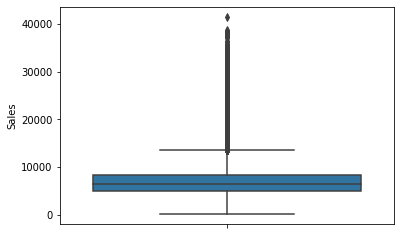

In [ ]:
#box-plot to find outliers in Sales
sns.boxplot(y="Sales", data = train_df)
plt.show()

In [ ]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = train_df["Sales"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 46
10 percentile value is 3762
20 percentile value is 4537
30 percentile value is 5165
40 percentile value is 5758
50 percentile value is 6369
60 percentile value is 7056
70 percentile value is 7867
80 percentile value is 8958
90 percentile value is 10771
100 percentile value is  41551


In [ ]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = train_df["Sales"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 10771
91 percentile value is 11052
92 percentile value is 11360
93 percentile value is 11722
94 percentile value is 12148
95 percentile value is 12668
96 percentile value is 13330
97 percentile value is 14209
98 percentile value is 15509
99 percentile value is 17789
100 percentile value is  41551


In [ ]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = train_df["Sales"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 17789
99.1 percentile value is 18138
99.2 percentile value is 18495
99.3 percentile value is 18904
99.4 percentile value is 19362
99.5 percentile value is 19909
99.6 percentile value is 20568
99.7 percentile value is 21403
99.8 percentile value is 22574
99.9 percentile value is 24672
100 percentile value is  41551


##### <font color="red">Remove Outliers in Sales - 99.9 percentile of data and after which is >= 24680.</font>

In [7]:
train_df = train_df[(train_df.Sales <= 24680)]

##### Customers

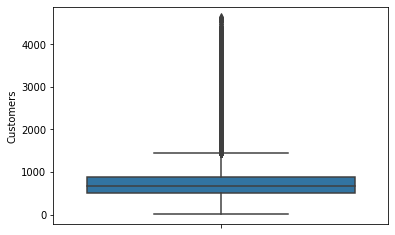

In [ ]:
#box-plot to find outliers in Sales
sns.boxplot(y="Customers", data = train_df)
plt.show()

In [ ]:
#calculating trip distance values at each percntile 0,10,20,30,40,50,60,70,80,90,100 
for i in range(0,100,10):
    var = train_df["Customers"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 8
10 percentile value is 408
20 percentile value is 486
30 percentile value is 550
40 percentile value is 611
50 percentile value is 675
60 percentile value is 748
70 percentile value is 838
80 percentile value is 958
90 percentile value is 1174
100 percentile value is  4645


In [ ]:
#calculating trip distance values at each percntile 90,91,92,93,94,95,96,97,98,99,100
for i in range(90,100):
    var = train_df["Customers"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 1174
91 percentile value is 1209
92 percentile value is 1250
93 percentile value is 1299
94 percentile value is 1358
95 percentile value is 1432
96 percentile value is 1531
97 percentile value is 1670
98 percentile value is 1889
99 percentile value is 2351
100 percentile value is  4645


In [ ]:
#calculating trip distance values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = train_df["Customers"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 2351
99.1 percentile value is 2430
99.2 percentile value is 2519
99.3 percentile value is 2620
99.4 percentile value is 2747
99.5 percentile value is 2894
99.6 percentile value is 3043
99.7 percentile value is 3178
99.8 percentile value is 3326
99.9 percentile value is 3509
100 percentile value is  4645


##### <font color="red">Remove Outliers in Customers - 99.9 percentile of data and after which is >= 3600.</font>

In [8]:
train_df = train_df[(train_df.Customers <= 3600)]

##### DayOfWeek

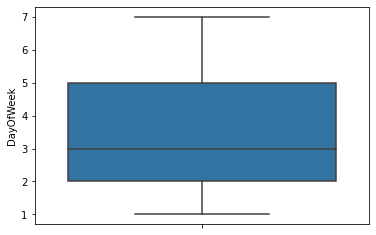

In [ ]:
#box-plot to find outliers in Sales
sns.boxplot(y="DayOfWeek", data = train_df)
plt.show()

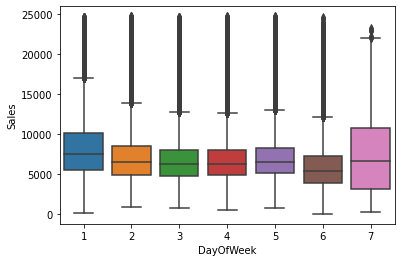

In [ ]:
#box-plot to find Sales by Day Sun to Sat (1 to 7)
sns.boxplot(x='DayOfWeek', y='Sales',data=train_df)
plt.show()

##### StateHoliday

In [ ]:
train_df['StateHoliday'].value_counts()

0    730047
0    112009
a       675
b       137
c        68
Name: StateHoliday, dtype: int64

##### <font color="red">Replacing 0 with '0' for data consistent in StateHoliday.</font>


In [9]:
train_df['StateHoliday'][train_df['StateHoliday'] == 0] = '0' 

In [ ]:
train_df['StateHoliday'].value_counts()

0    842056
a       675
b       137
c        68
Name: StateHoliday, dtype: int64

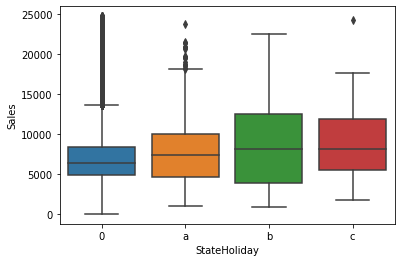

In [ ]:
 #box-plot to find Sales on State Holidays ( a = public holiday, b = Easter holiday, c = Christmas)
 sns.boxplot(x='StateHoliday', y='Sales',data=train_df)
 plt.show()

##### SchoolHoliday

In [ ]:
train_df['SchoolHoliday'].value_counts()

0    679754
1    163182
Name: SchoolHoliday, dtype: int64

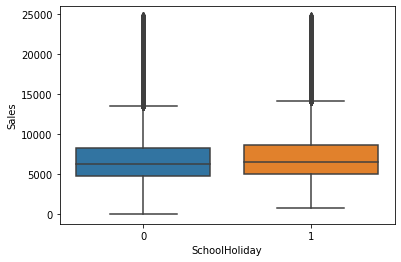

In [ ]:
 #box-plot to find Sales on School Holidays
 sns.boxplot(x='SchoolHoliday', y='Sales',data=train_df)
 plt.show()

##### Date
*   Min Date: 2013-01-01
*   Max Date: 2015-07-31

In [ ]:
min(train_df['Date'].unique()), max(train_df['Date'].unique())

('2013-01-01', '2015-07-31')

##### Promo

In [ ]:
train_df['Promo'].value_counts()

0    466924
1    376012
Name: Promo, dtype: int64

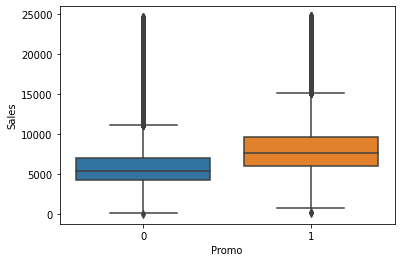

In [ ]:
 #box-plot to find impact of Promo on Sales
 sns.boxplot(x='Promo', y='Sales',data=train_df)
 plt.show()

##### Open
*   Left with only one value in Open i.e., 1, i.e., Store is Opened

In [ ]:
train_df['Open'].value_counts()

1    842936
Name: Open, dtype: int64

In [ ]:
train_df['Sales'].describe() # we can also use train_df.Sales.describe()

count    842936.000000
mean       6927.876838
std        3019.939416
min          46.000000
25%        4857.000000
50%        6363.000000
75%        8346.000000
max       24680.000000
Name: Sales, dtype: float64

### EDA - Train Data Analysis

*   There are no null data found in any of the columns. Date, StateHoliday are of type Object remaining are int64. Feature with type Object need to be encoded.
*   Min Sales and Max Sales are 0 and 4155. 16% (172871) of data is has NaN as Sales because Store Closed (172817) on those days.
*   More Sales reported on Sunday, seems store is closed on Saturday or no Sales.
*   Outliers in Sales - 99.9 percentile of data is >= 24680.
*   Outliers in Customers - 99.9 percentile of data is >= 3600.
*   Promo applied on only 50% of data. Considerable impact of Promo on Sales.
*   StateHoliday column contains two different values 0 (count=131072) and '0' (count=855087).
*   StateHoliday affected Sales of Stores.
*   Different StateHoliday applied on only 3% of data.
*   SchoolHoliday applied on only 17% of data, has not much impact on Store Sales.

#### <font color="red">Reading store data</font>

In [10]:
#Read the store dataset
store_df = pd.read_csv(r"store.csv")

#check the info of the dataset
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


##### Distinct Values in Features (of type object) StoreType, Assortment, PromoInterval

In [ ]:
print("Distinct values in StoreType: ", store_df['StoreType'].unique())
print("Distinct values in Assortment: ", store_df['Assortment'].unique())
print("Distinct values in PromoInterval: ", store_df['PromoInterval'].unique())
print("Distinct values in Promo2", store_df['Promo2'].unique())

Distinct values in StoreType:  ['c' 'a' 'd' 'b']
Distinct values in Assortment:  ['a' 'c' 'b']
Distinct values in PromoInterval:  [nan 'Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']
Distinct values in Promo2 [0 1]


##### CompetitionDistance

In [ ]:
store_df[['Store','CompetitionDistance']][store_df['CompetitionDistance'].isnull()]

,Store,CompetitionDistance
290,291,NaN
621,622,NaN
878,879,NaN


##### <font color="red">Replace CompetitionDistance of null/NaN with median (2325) of CompetitionDistance.</font>

In [11]:
store_df["CompetitionDistance"][store_df.CompetitionDistance.isnull()] = store_df['CompetitionDistance'].median()

##### CompetitionOpenSinceYear

In [ ]:
store_df["CompetitionOpenSinceYear"].value_counts()

2013.0    83
2012.0    82
2014.0    70
2005.0    62
2010.0    55
2008.0    54
2009.0    54
2011.0    54
2007.0    48
2006.0    47
2015.0    38
2002.0    27
2004.0    22
2003.0    19
2001.0    16
2000.0    10
1999.0     8
1990.0     5
1995.0     2
1994.0     2
1961.0     1
1900.0     1
1998.0     1
Name: CompetitionOpenSinceYear, dtype: int64

In [ ]:
store_df['CompetitionOpenSinceYear'][store_df['CompetitionOpenSinceYear'].isnull()]

11     NaN
12     NaN
15     NaN
18     NaN
21     NaN
        ..
1095   NaN
1099   NaN
1112   NaN
1113   NaN
1114   NaN
Name: CompetitionOpenSinceYear, Length: 354, dtype: float64

##### CompetitionOpenSinceMonth

In [ ]:
store_df["CompetitionOpenSinceMonth"].value_counts()

9.0     125
4.0      94
11.0     92
3.0      70
7.0      67
12.0     64
10.0     61
6.0      50
5.0      44
2.0      41
8.0      39
1.0      14
Name: CompetitionOpenSinceMonth, dtype: int64

In [ ]:
store_df['CompetitionOpenSinceMonth'][store_df['CompetitionOpenSinceMonth'].isnull()]

11     NaN
12     NaN
15     NaN
18     NaN
21     NaN
        ..
1095   NaN
1099   NaN
1112   NaN
1113   NaN
1114   NaN
Name: CompetitionOpenSinceMonth, Length: 354, dtype: float64

##### StoreType

In [ ]:
# Differentiates between 4 different store models: a, b, c, d
store_df['StoreType'].value_counts()

a    602
d    348
c    148
b     17
Name: StoreType, dtype: int64

In [ ]:
store_df['StoreType'][store_df['StoreType'].isnull()]

Series([], Name: StoreType, dtype: object)

##### Assortment

In [ ]:
# Describes an assortment level: a = basic, b = extra, c = extended
# Assortment = a miscellaneous collection of things or people.
store_df['Assortment'].value_counts()

a    593
c    513
b      9
Name: Assortment, dtype: int64

In [ ]:
store_df['Assortment'][store_df['Assortment'].isnull()]

Series([], Name: Assortment, dtype: object)

##### Promo2

In [ ]:
store_df['Promo2'].value_counts()

1    571
0    544
Name: Promo2, dtype: int64

In [ ]:
store_df['Promo2'][store_df['Promo2'].isnull()]

Series([], Name: Promo2, dtype: int64)

##### Promo2SinceWeek

In [ ]:
store_df['Promo2SinceWeek'].value_counts()

14.0    81
40.0    77
31.0    44
10.0    42
5.0     39
1.0     35
37.0    35
13.0    34
45.0    34
22.0    33
18.0    29
35.0    25
9.0     14
27.0    11
36.0    10
48.0     9
39.0     6
23.0     5
44.0     3
6.0      1
26.0     1
50.0     1
49.0     1
28.0     1
Name: Promo2SinceWeek, dtype: int64

In [ ]:
store_df['Promo2SinceWeek'][store_df['Promo2SinceWeek'].isnull()]

0      NaN
3      NaN
4      NaN
5      NaN
6      NaN
        ..
1107   NaN
1109   NaN
1111   NaN
1112   NaN
1113   NaN
Name: Promo2SinceWeek, Length: 544, dtype: float64

##### Promo2SinceYear

In [ ]:
store_df['Promo2SinceYear'].value_counts()

2011.0    128
2013.0    120
2014.0     95
2012.0     81
2009.0     73
2010.0     64
2015.0     10
Name: Promo2SinceYear, dtype: int64

In [ ]:
store_df['Promo2SinceYear'][store_df['Promo2SinceYear'].isnull()]

0      NaN
3      NaN
4      NaN
5      NaN
6      NaN
        ..
1107   NaN
1109   NaN
1111   NaN
1112   NaN
1113   NaN
Name: Promo2SinceYear, Length: 544, dtype: float64

##### PromoInterval

In [ ]:
store_df['PromoInterval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: PromoInterval, dtype: int64

In [ ]:
store_df['PromoInterval'][store_df['PromoInterval'].isnull()]

0       NaN
3       NaN
4       NaN
5       NaN
6       NaN
       ... 
1107    NaN
1109    NaN
1111    NaN
1112    NaN
1113    NaN
Name: PromoInterval, Length: 544, dtype: object

##### <font color="red">Replace NaN/null values in CompetitionOpenSinceYear, CompetitionOpenSinceMonth, Promo2SinceYear, Promo2SinceWeek, PromoInterval with 0.</font>

In [12]:
store_df.fillna(0, inplace=True)

In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   float64
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


### EDA - Store Data Analysis

*   CompetitionDistance is null/NaN for 3 stores.
*   354 stores don't have CompetitionOpenSinceMonth, CompetitionOpenSinceYear are defined, i.e., null/NaN. Eventhoguh they have CompetitionDistance defined.
*   554 stores don't have Promo2SinceWeek, Promo2SinceYear, PromoInterval are defined i.e., null/NaN.
*   Found NaN/null values in CompetitionOpenSinceYear, CompetitionOpenSinceMonth, Promo2SinceYear, Promo2SinceWeek, PromoInterval

## <font color="red">Merging Train Data with Store Data based on Store (Unique Id)</font>

In [13]:
train_merge_store_df = pd.merge(train_df, store_df, on='Store', how='left')

In [14]:
train_merge_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842936 entries, 0 to 842935
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      842936 non-null  int64  
 1   DayOfWeek                  842936 non-null  int64  
 2   Date                       842936 non-null  object 
 3   Sales                      842936 non-null  int64  
 4   Customers                  842936 non-null  int64  
 5   Open                       842936 non-null  int64  
 6   Promo                      842936 non-null  int64  
 7   StateHoliday               842936 non-null  object 
 8   SchoolHoliday              842936 non-null  int64  
 9   StoreType                  842936 non-null  object 
 10  Assortment                 842936 non-null  object 
 11  CompetitionDistance        842936 non-null  float64
 12  CompetitionOpenSinceMonth  842936 non-null  float64
 13  CompetitionOpenSinceYear   84

##### <font color="red">Adding belew new features based on Feature Date.</font>
*   Year
*   Month
*   Week

###### Converting Date feature dtype from 'object' to 'datetime64[ns]' to extract features from it

In [15]:
train_merge_store_df['Date'] = pd.to_datetime(train_merge_store_df['Date'], errors='coerce')

In [16]:
train_merge_store_df['Year'] = train_merge_store_df.Date.dt.year
train_merge_store_df['Month'] = train_merge_store_df.Date.dt.month
train_merge_store_df['Week'] = train_merge_store_df.Date.dt.week

##### <font color="red">Sorting Train Data by Date</font>

In [17]:
train_merge_store_df = train_merge_store_df.sort_values(by='Date')

In [ ]:
train_merge_store_df['Year'].value_counts()

2013    337348
2014    309838
2015    195750
Name: Year, dtype: int64

## Univariate Analysis

###### Sales against StoreType
###### Observation: Sales data is overlappped, cannot distinguish

In [ ]:
StoreType_a = train_merge_store_df.loc[train_merge_store_df["StoreType"]=='a']
StoreType_b = train_merge_store_df.loc[train_merge_store_df["StoreType"]=='b']
StoreType_c = train_merge_store_df.loc[train_merge_store_df["StoreType"]=='c']
StoreType_d = train_merge_store_df.loc[train_merge_store_df["StoreType"]=='d']

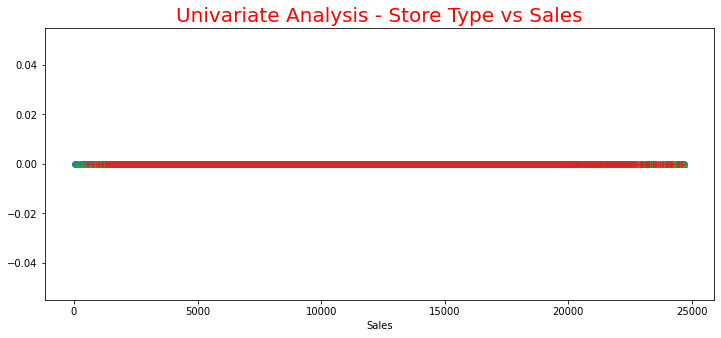

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 5.0)
plt.plot(StoreType_a["Sales"],np.zeros_like(StoreType_a["Sales"]),"o")
plt.plot(StoreType_b["Sales"],np.zeros_like(StoreType_b["Sales"]),"*")
plt.plot(StoreType_c["Sales"],np.zeros_like(StoreType_c["Sales"]),"^")
plt.plot(StoreType_d["Sales"],np.zeros_like(StoreType_d["Sales"]),"+")
plt.xlabel("Sales")
plt.title(label="Univariate Analysis - Store Type vs Sales",fontsize=20,color='red')
#plt.legend()#loc ="lower right")
plt.show()

###### Sales against Assortment
###### Observation: Sales data is overlapped, cannot distinguish

In [ ]:
AssortmentType_a = train_merge_store_df.loc[train_merge_store_df["Assortment"]=='a']
AssortmentType_b = train_merge_store_df.loc[train_merge_store_df["Assortment"]=='b']
AssortmentType_c = train_merge_store_df.loc[train_merge_store_df["Assortment"]=='c']

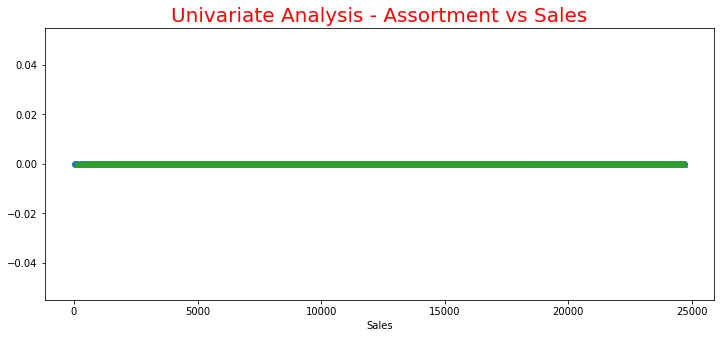

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 5.0)
plt.plot(AssortmentType_a["Sales"],np.zeros_like(AssortmentType_a["Sales"]),"o")
plt.plot(AssortmentType_b["Sales"],np.zeros_like(AssortmentType_b["Sales"]),"*")
plt.plot(AssortmentType_c["Sales"],np.zeros_like(AssortmentType_c["Sales"]),"^")
plt.xlabel("Sales")
plt.title(label="Univariate Analysis - Assortment vs Sales",fontsize=20,color='red')
#plt.legend()#loc ="lower right")
plt.show()

###### Sales against Promo
###### Observation: Sales data is overlappped, cannot distinguish

In [ ]:
PromoType_0 = train_merge_store_df.loc[train_merge_store_df["Promo"]==0]
PromoType_1 = train_merge_store_df.loc[train_merge_store_df["Promo"]==1]

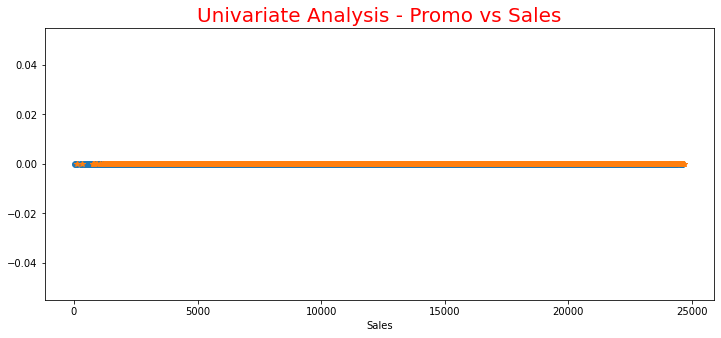

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 5.0)
plt.plot(PromoType_0["Sales"],np.zeros_like(PromoType_0["Sales"]),"o")
plt.plot(PromoType_1["Sales"],np.zeros_like(PromoType_1["Sales"]),"*")
plt.xlabel("Sales")
plt.title(label="Univariate Analysis - Promo vs Sales",fontsize=20,color='red')
#plt.legend()#loc ="lower right")
plt.show()

###### Observations:
###### Univariate Analysis with above method, cannot distiguish Sales data against the features StoreType, Assortment, Promo

#### Univariate Analysis on Sales, Customers, CompetitionDistance

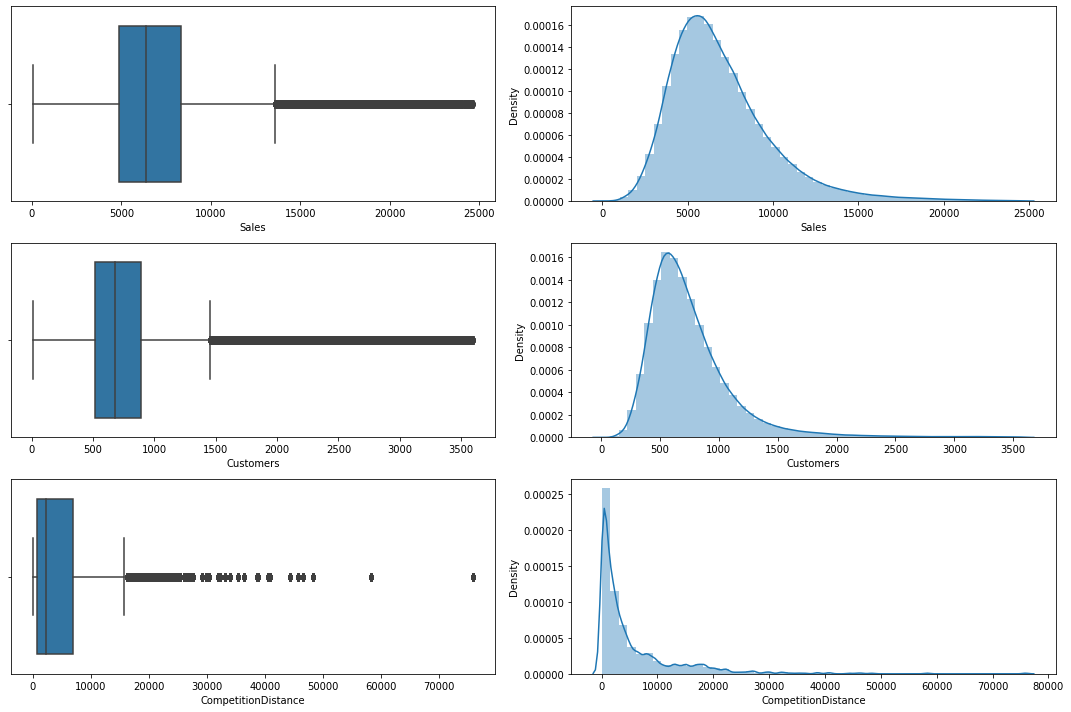

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (15, 10))
sns.boxplot(x= train_merge_store_df['Sales'], ax = ax[0,0])
sns.distplot(train_merge_store_df['Sales'], ax = ax[0,1])
sns.boxplot(x= train_merge_store_df['Customers'], ax = ax[1,0])
sns.distplot(train_merge_store_df['Customers'], ax = ax[1,1])
sns.boxplot(x= train_merge_store_df['CompetitionDistance'], ax = ax[2,0])
sns.distplot(train_merge_store_df['CompetitionDistance'], ax = ax[2,1])
plt.tight_layout()

In [ ]:
print("Sales Skewness: %f" %train_merge_store_df['Sales'].skew())
print("Sales Kurtosis: %f" %train_merge_store_df['Sales'].kurt())

Sales Skewness: 0.902208
Sales Kurtosis: 0.885316


### Observations:

Sales data is distributed mostly between 3000 to 9000; mostly symmetrically distributed.
Customers data is distributed mostly between 250 to 1100; mostly symmetrically distributed.
CompetitionDistance data is distributed mostly between 0 to 400, mostly right skewed.

#### Univariate Analysis using Box Plots

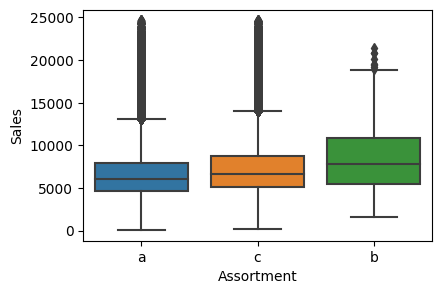

In [ ]:
#box-plot to find Sales for Assortment (a = basic, b = extra, c = extended)
plt.rcParams['figure.figsize'] = (4.5, 3.0)
sns.boxplot(x='Assortment', y='Sales',data=train_merge_store_df)
plt.show()

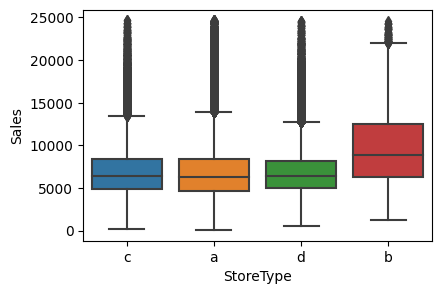

In [ ]:
 #box-plot to find Sales for StoreType (a, b, c, d)
 sns.boxplot(x='StoreType', y='Sales',data=train_merge_store_df)
 plt.show()

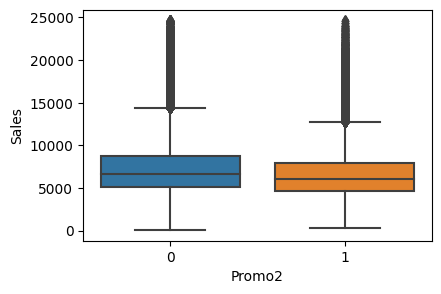

In [ ]:
 #box-plot to find Sales for Promo2
 sns.boxplot(x='Promo2', y='Sales',data=train_merge_store_df)
 plt.show()

[None, None, None, None, None, None, None, None]

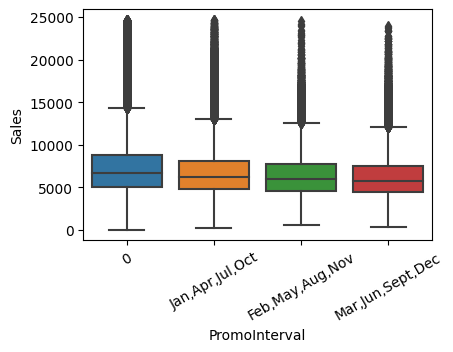

In [ ]:
#box-plot to find Sales for PromoInterval
#sns.boxplot(x='PromoInterval', y='Sales', data=train_merge_store_df)
#plt.show()

ax = sns.boxplot(x='PromoInterval', y='Sales', data=train_merge_store_df)#hue='target', 
plt.setp(ax.get_xticklabels(), rotation=30)

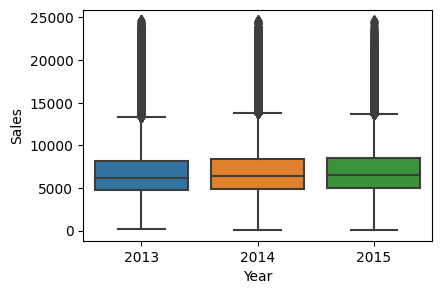

In [ ]:
 #box-plot to find Sales for Year
 sns.boxplot(x='Year', y='Sales',data=train_merge_store_df)
 plt.show()

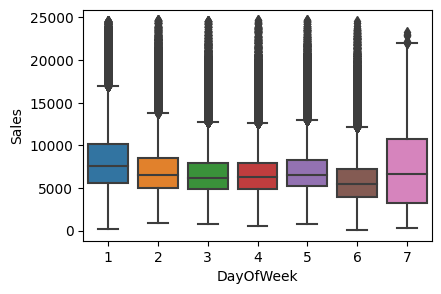

In [ ]:
 #box-plot to find Sales by Day (Sun to Sat) (0 to 6)
 sns.boxplot(x='DayOfWeek', y='Sales',data=train_merge_store_df)
 plt.show()

#### Observations:
After Box plot, data don't have outliers

### Bi-Variate Analysis

In [ ]:
plt.figure(1)

<Figure size 450x300 with 0 Axes>

<Figure size 450x300 with 0 Axes>

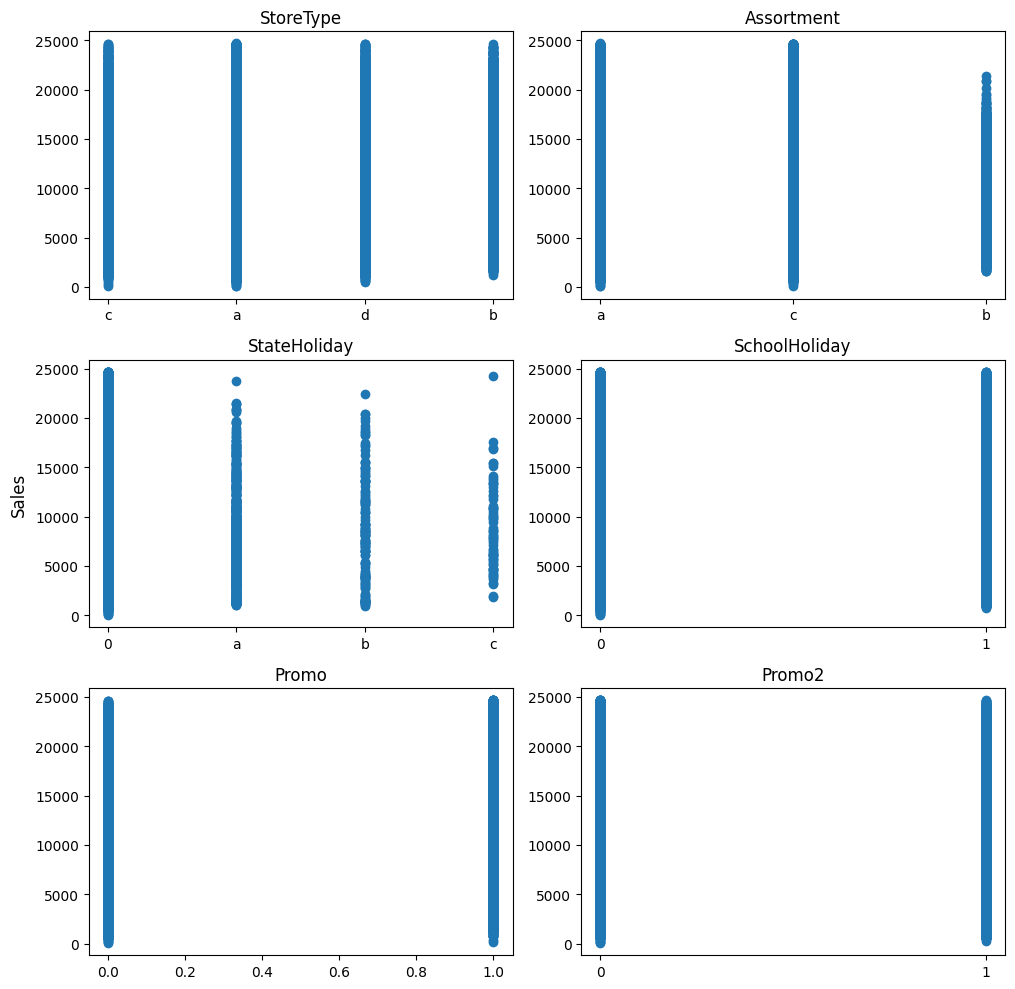

In [ ]:
f,axarr = plt.subplots(3,2, figsize=(10,10))
sales = train_merge_store_df.Sales.values
axarr[0,0].scatter(train_merge_store_df.StoreType.values, sales)
axarr[0,0].set_title('StoreType')
axarr[0,1].scatter(train_merge_store_df.Assortment.values, sales)
axarr[0,1].set_title('Assortment')
axarr[1,0].scatter(train_merge_store_df.StateHoliday.values, sales)
axarr[1,0].set_title('StateHoliday')
axarr[1,1].scatter(train_merge_store_df.SchoolHoliday.values, sales)
axarr[1,1].set_title('SchoolHoliday')
# Rename x axis label as 0, 1
axarr[1,1].set_xticks([0,1])
axarr[1,1].set_xticklabels(["0","1"])

axarr[2,0].scatter(train_merge_store_df.Promo.values, sales)
axarr[2,0].set_title('Promo')
axarr[2,1].scatter(train_merge_store_df["Promo2"].values, sales)
axarr[2,1].set_title('Promo2')
# Rename x axis label as 0, 1
axarr[2,1].set_xticks([0,1])
axarr[2,1].set_xticklabels(["0","1"])
#axarr[3,0].scatter(train_merge_store_df.PromoInterval.values, sales)
#axarr[3,0].set_title('PromoInterval')
#axarr[3,1].axis("off") # For any absent, like if we have only 7 of 8 to plot
f.text(-0.01, 0.5, 'Sales', va='center', rotation='vertical', fontsize = 12)
plt.tight_layout()
plt.show()

#### Observations:
*   Customers vs Sales by StoreType - As per below 1st graph, More Sales and Customers for StoreType b than d than a than c.
*   As per 2nd graph, Sales are more for StoreType b, for other StoreTypes Sales are equal.
*   As per 3rd graph, Customers are more for StoreType b, for other StoreType considerably less.

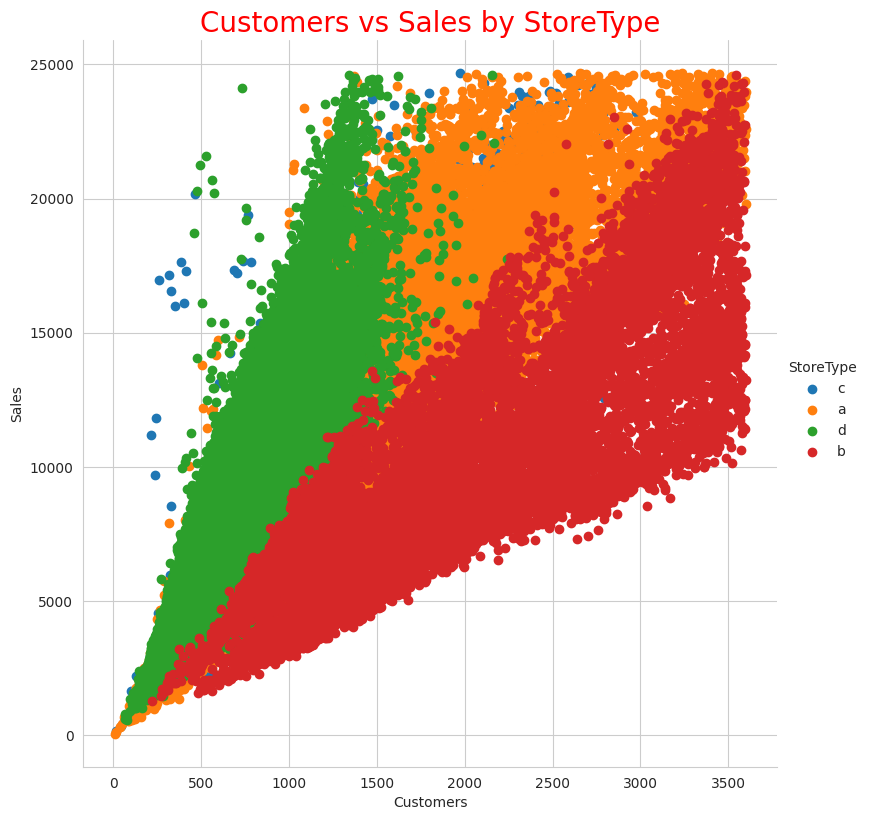

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train_merge_store_df, hue='StoreType', height=8).map(plt.scatter,"Customers","Sales").add_legend()
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.title(label="Customers vs Sales by StoreType",fontsize=20,color='red')
plt.show()

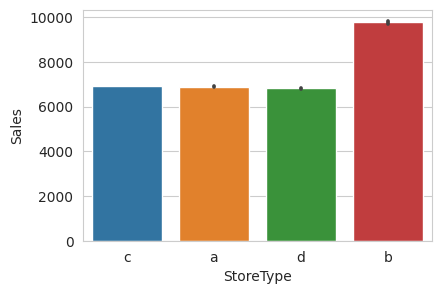

In [ ]:
sns.barplot(x='StoreType', y='Sales',data=train_merge_store_df)
plt.show()

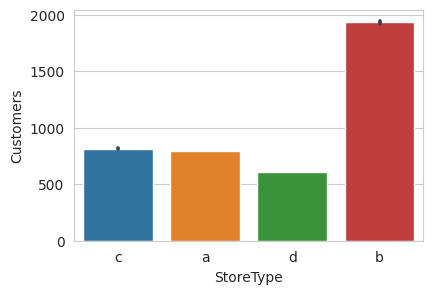

In [ ]:
sns.barplot(x='StoreType', y='Customers',data=train_merge_store_df)
plt.show()

#### Observations:
*    Customers vs Sales by DayOfWeek -
As per below 1st graph, observing more Sales and Customers on Friday(6) and Saturday(7).
*    As per below 2nd graph, Sales are more on Sunday(1) and Saturday(7).
*    As per below 3rd graph, Customer are more on Saturday (7)

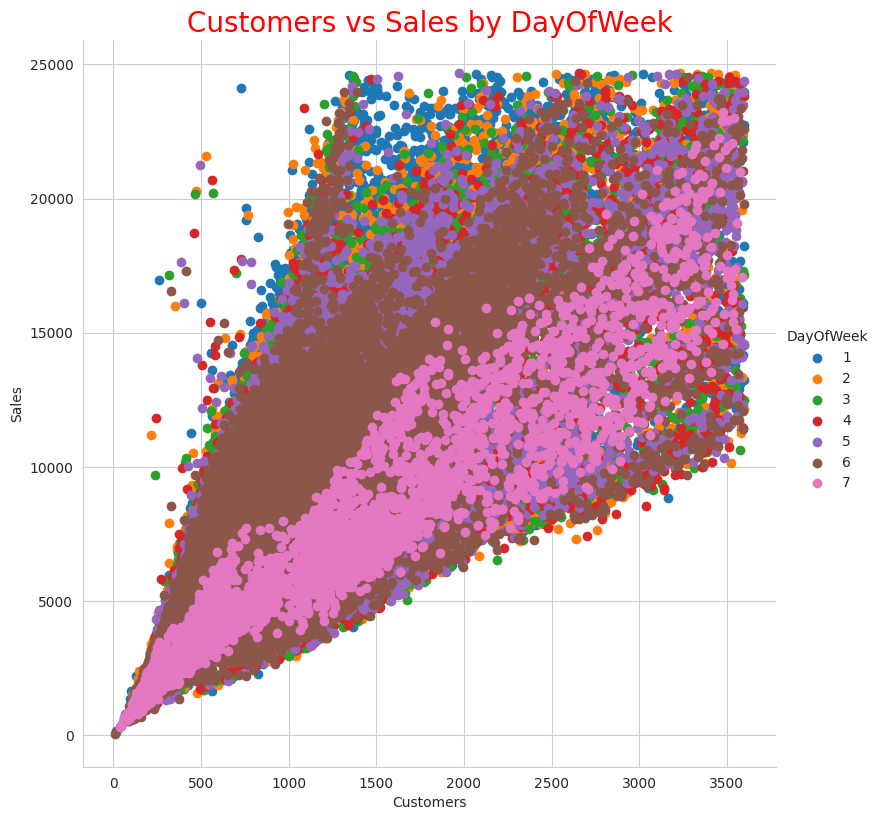

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train_merge_store_df, hue='DayOfWeek', height=8).map(plt.scatter,"Customers","Sales").add_legend()
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.title(label="Customers vs Sales by DayOfWeek",fontsize=20,color='red')
plt.show()

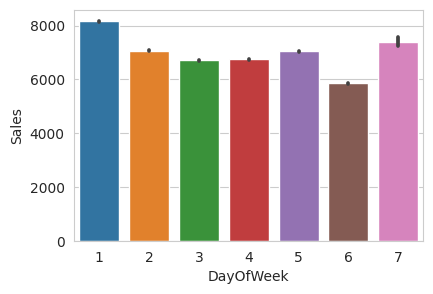

In [ ]:
sns.barplot(x='DayOfWeek', y='Sales',data=train_merge_store_df)
plt.show()

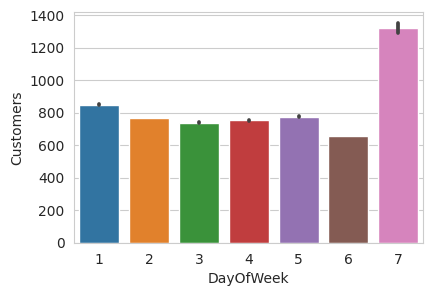

In [ ]:
sns.barplot(x='DayOfWeek', y='Customers',data=train_merge_store_df)
plt.show()

##### Observations:
*   Customers vs Sales by Assortment - As per below 1st graph Sales and Customers are more for Assortment c than b than a.
*   As per below 2nd graph, Sales are more for Assortment b.
*   As per below 3rd graph, Customers are considerably more for Assortment b.

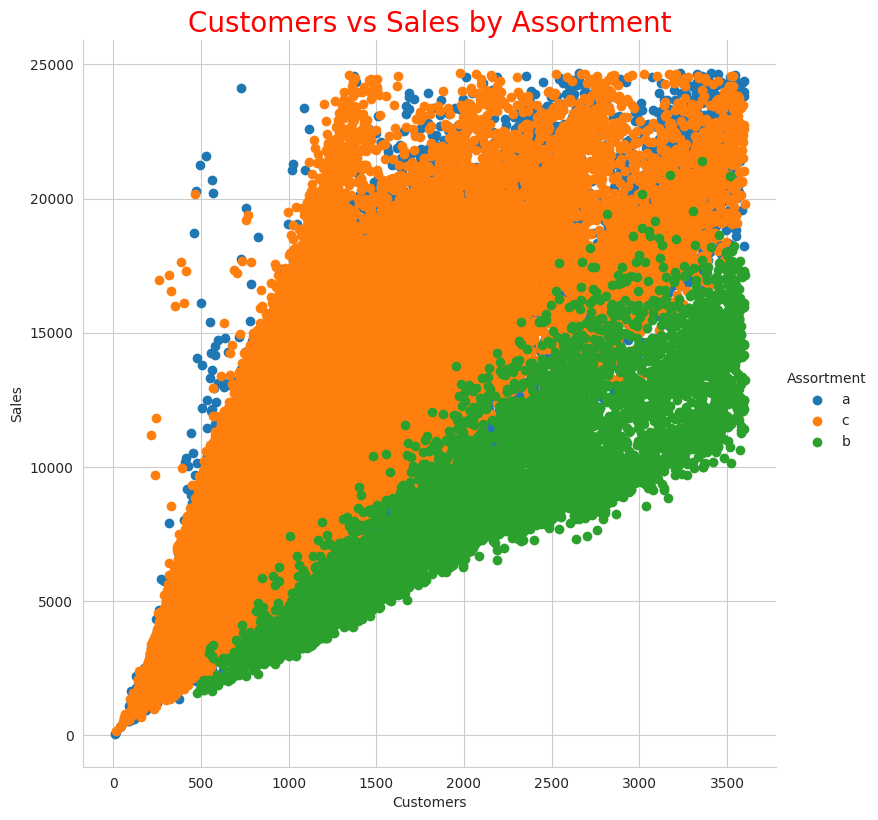

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train_merge_store_df, hue='Assortment', height=8).map(plt.scatter,"Customers","Sales").add_legend()
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.title(label="Customers vs Sales by Assortment",fontsize=20,color='red')
plt.show()

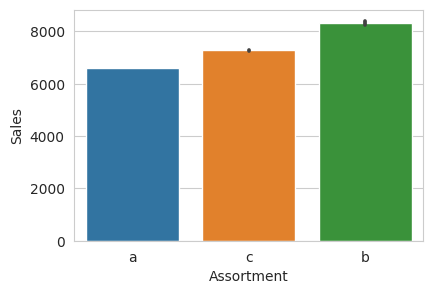

In [ ]:
sns.barplot(x='Assortment', y='Sales',data=train_merge_store_df)
plt.show()

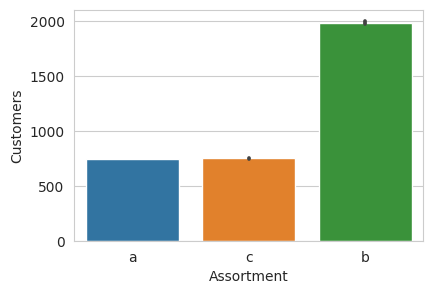

In [ ]:
sns.barplot(x='Assortment', y='Customers',data=train_merge_store_df)
plt.show()

#### Observations:
*  Customers vs Sales by StateHoliday - As per below 1st graph, Sales and Customers are more on Non StateHolidays.
*  As per below 2nd graph, Sales are more on Christmas 
*  As per below 3rd graph, Customers are more on Easter holiday

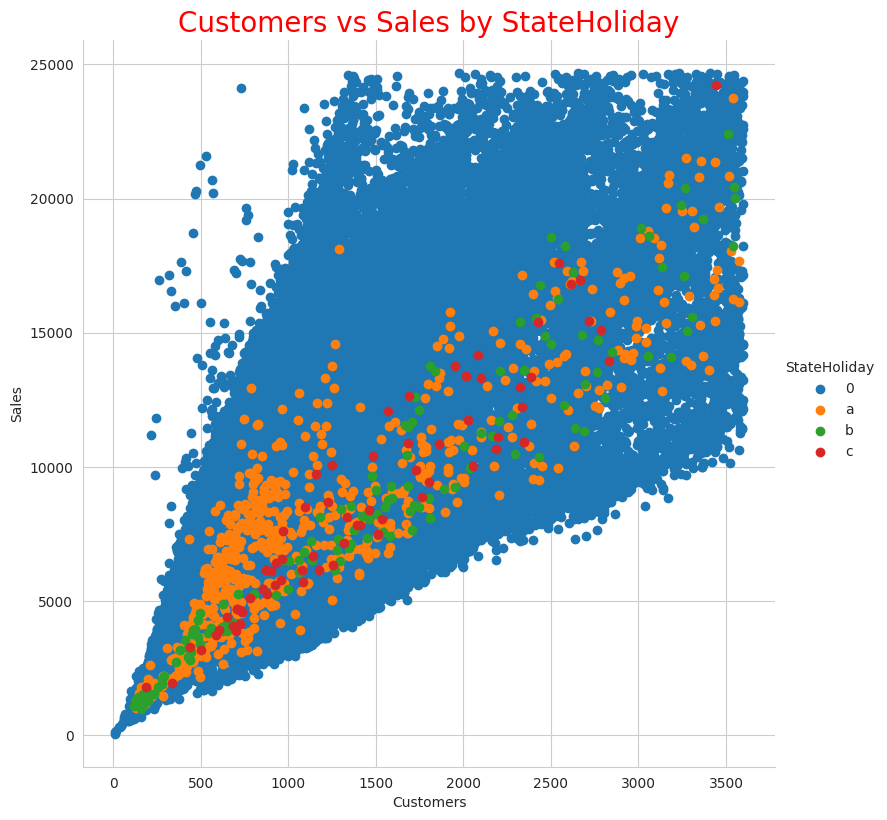

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train_merge_store_df, hue='StateHoliday', height=8).map(plt.scatter,"Customers","Sales").add_legend()
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.title(label="Customers vs Sales by StateHoliday",fontsize=20,color='red')
plt.show()

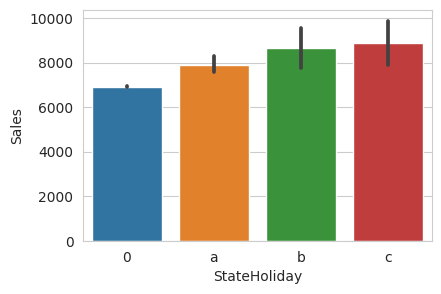

In [ ]:
sns.barplot(x='StateHoliday', y='Sales',data=train_merge_store_df)
plt.show()

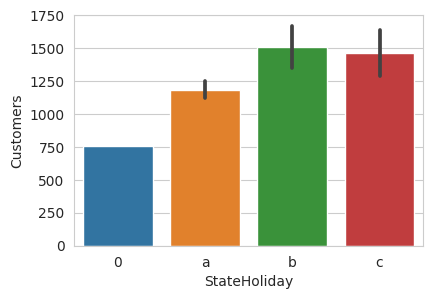

In [ ]:
sns.barplot(x='StateHoliday', y='Customers',data=train_merge_store_df)
plt.show()

#### Observations:
*   Customers vs Sales by SchoolHoliday - As per below graph, Sales and Customers are affected (reduced) by SchoolHoliday.
*   As per below 2nd graph, Sales impacted(reduced) on SchoolHoliday
*   As per below 3rd graph, Customers impacted(reduced) on SchoolHoliday 

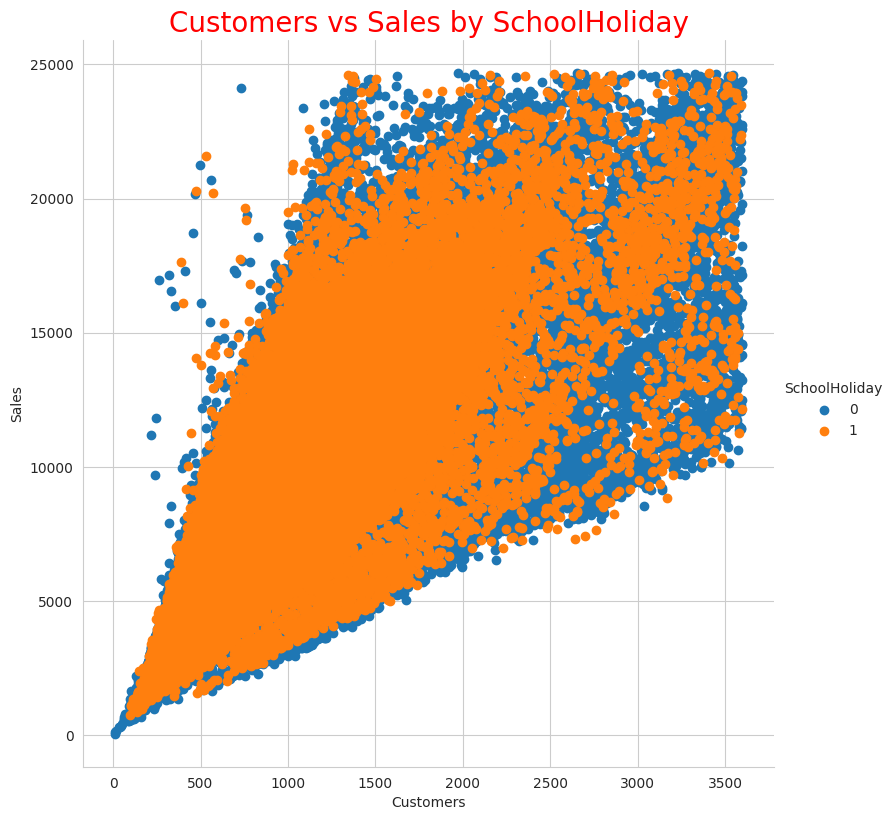

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train_merge_store_df, hue='SchoolHoliday', height=8).map(plt.scatter,"Customers","Sales").add_legend()
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.title(label="Customers vs Sales by SchoolHoliday",fontsize=20,color='red')
plt.show()

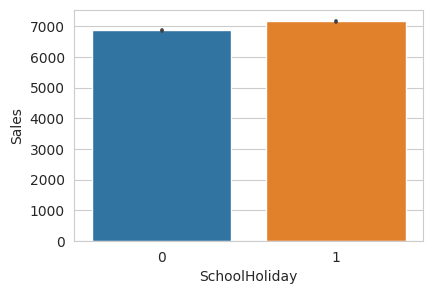

In [ ]:
sns.barplot(x='SchoolHoliday', y='Sales',data=train_merge_store_df)
plt.show()

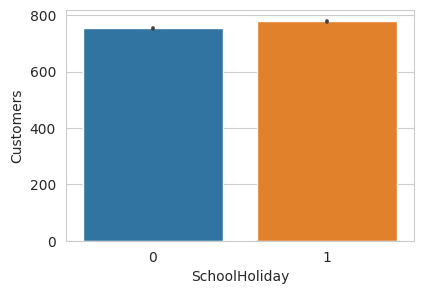

In [ ]:
sns.barplot(x='SchoolHoliday', y='Customers',data=train_merge_store_df)
plt.show()

#### Observations:
*   Customers vs Sales by Promo - As per below 1st graph - Sales and Customers increased because of Promo.
*   As per below 2nd graph, Sales more when Promo is given.
*   As per below 3rd graph, Customer are attracted by Promo.

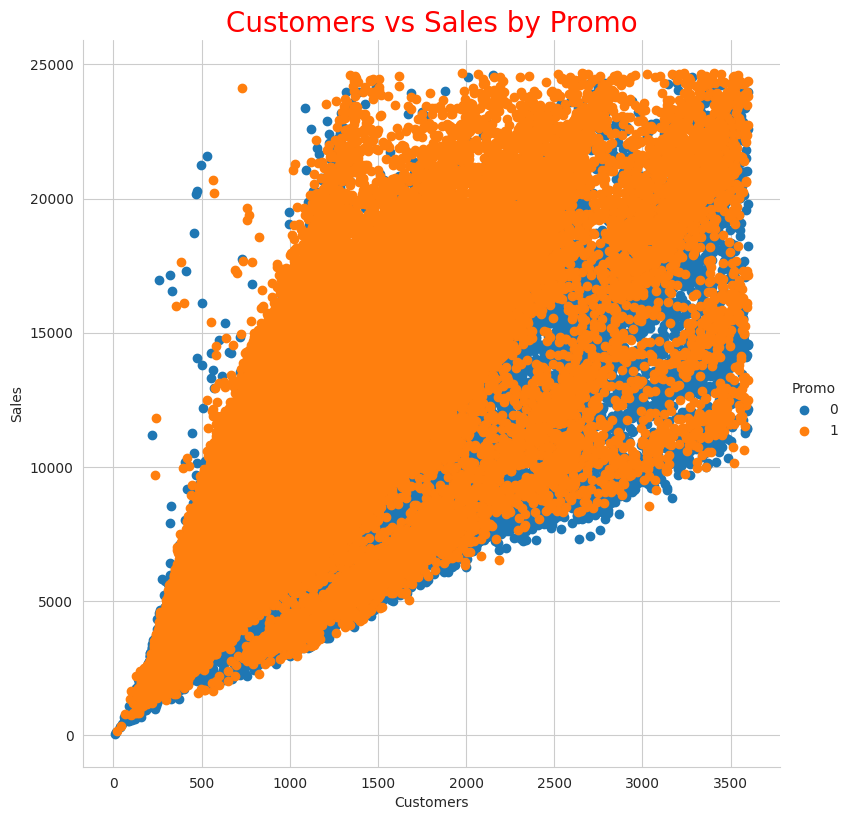

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train_merge_store_df, hue='Promo', height=8).map(plt.scatter,"Customers","Sales").add_legend()
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.title(label="Customers vs Sales by Promo",fontsize=20,color='red')
plt.show()

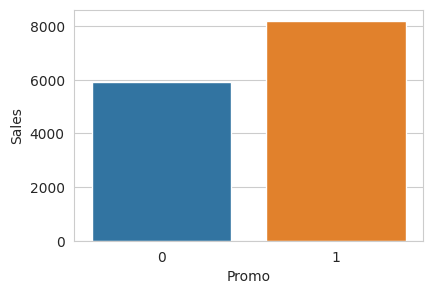

In [ ]:
sns.barplot(x='Promo', y='Sales',data=train_merge_store_df)
plt.show()

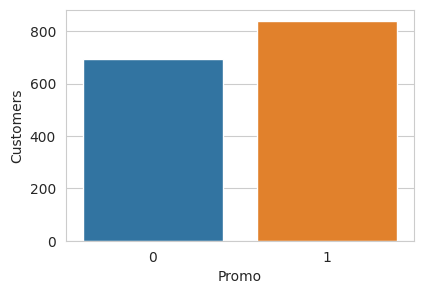

In [ ]:
sns.barplot(x='Promo', y='Customers',data=train_merge_store_df)
plt.show()

#### Observations:
*   Customers vs Sales by Promo2 - As per below 1st graph - Sales and Customers increased because of Promo2.
*   As per below 2nd graph, Sales were not improved when Promo2 was given.
*   As per below 3rd graph, Customers were not attracted with Promo2.

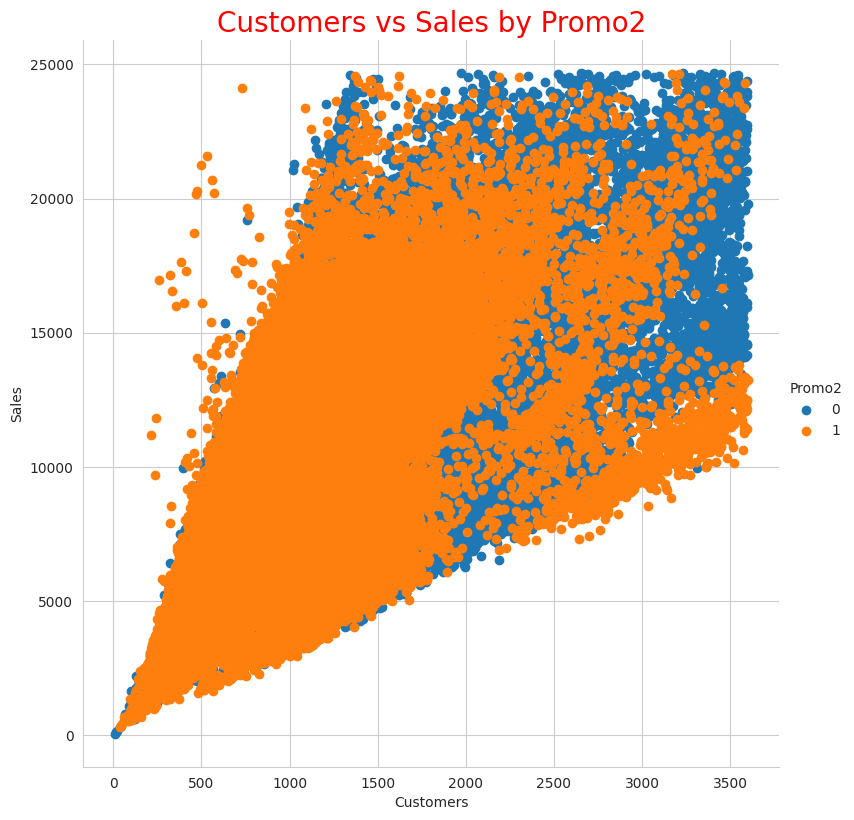

In [ ]:
sns.set_style("whitegrid")
sns.FacetGrid(train_merge_store_df, hue='Promo2', height=8).map(plt.scatter,"Customers","Sales").add_legend()
plt.xlabel("Customers")
plt.ylabel("Sales")
plt.title(label="Customers vs Sales by Promo2",fontsize=20,color='red')
plt.show()

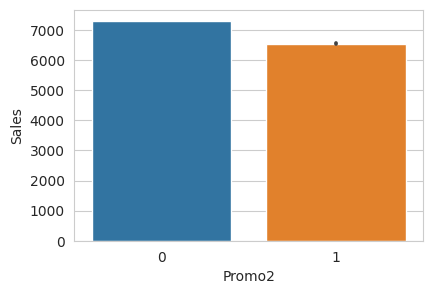

In [ ]:
sns.barplot(x='Promo2', y='Sales',data=train_merge_store_df)
plt.show()

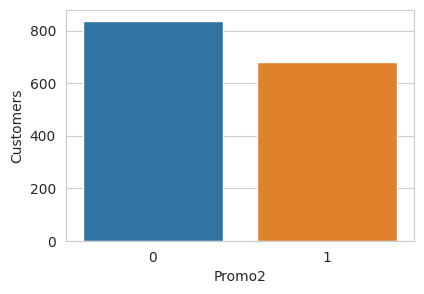

In [ ]:
sns.barplot(x='Promo2', y='Customers',data=train_merge_store_df)
plt.show()

## Multivariate Analysis

### Observations as per below histogram:
*   Store: All stores opened same number of days.
*   DayOfweek: No sales on Saturday.
*   Sales: Distributed normally.
*   Customers: Distributed normally.
*   Open: We have only data with Stores opened.
*   Promo: Data has 380K with Promo.
*   SchoolHoliday: Data contain around 180K SchoolHolidays.
*   CompetitionDistance: Competition is right skewed, most of the copetitors are nearer.
*   Year: we have data related to 2013, 2014, 2015.

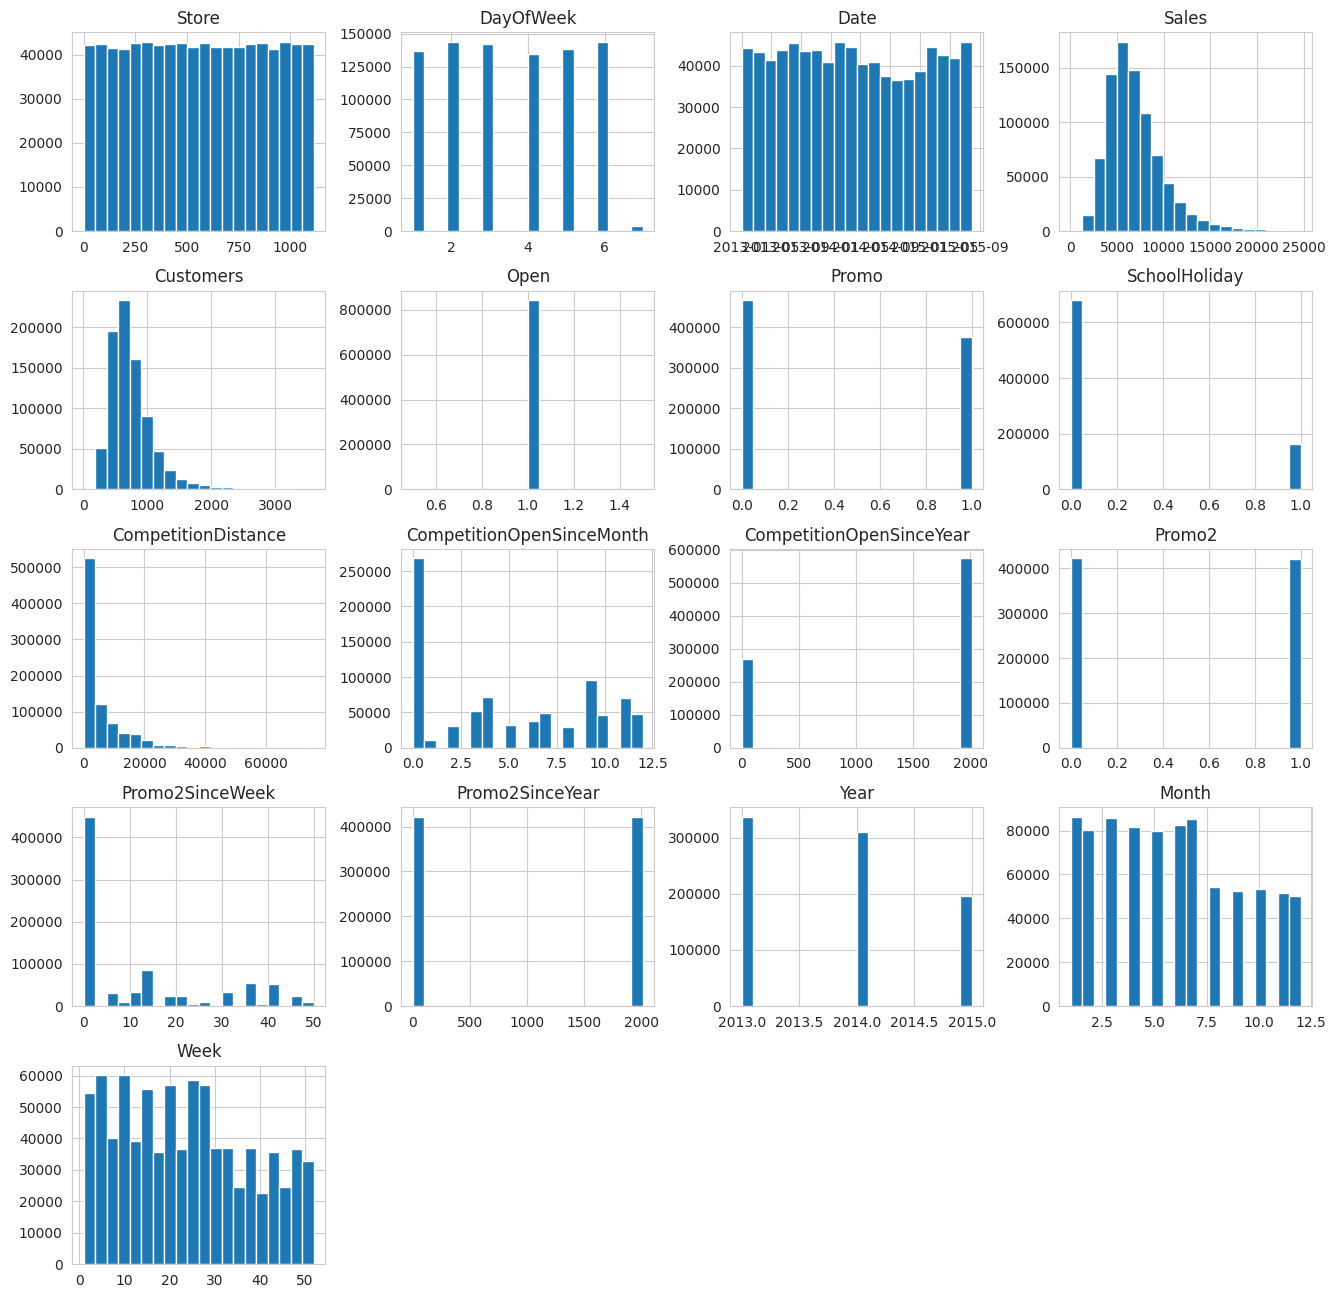

In [ ]:
train_merge_store_df.hist(figsize=(16,16),bins=20)
plt.show()

### Observations as per below Pariplot:
*   Sales vs Customer: Sales and Customer are proportional to each other
*   Sales vs CompetitionDistance: Sales more as the CompetitionDistance
*   Sales vs Promo: Sales not much impacted by Promo.
*   Sales vs Promo2: Sales not much impacted by Promo2.

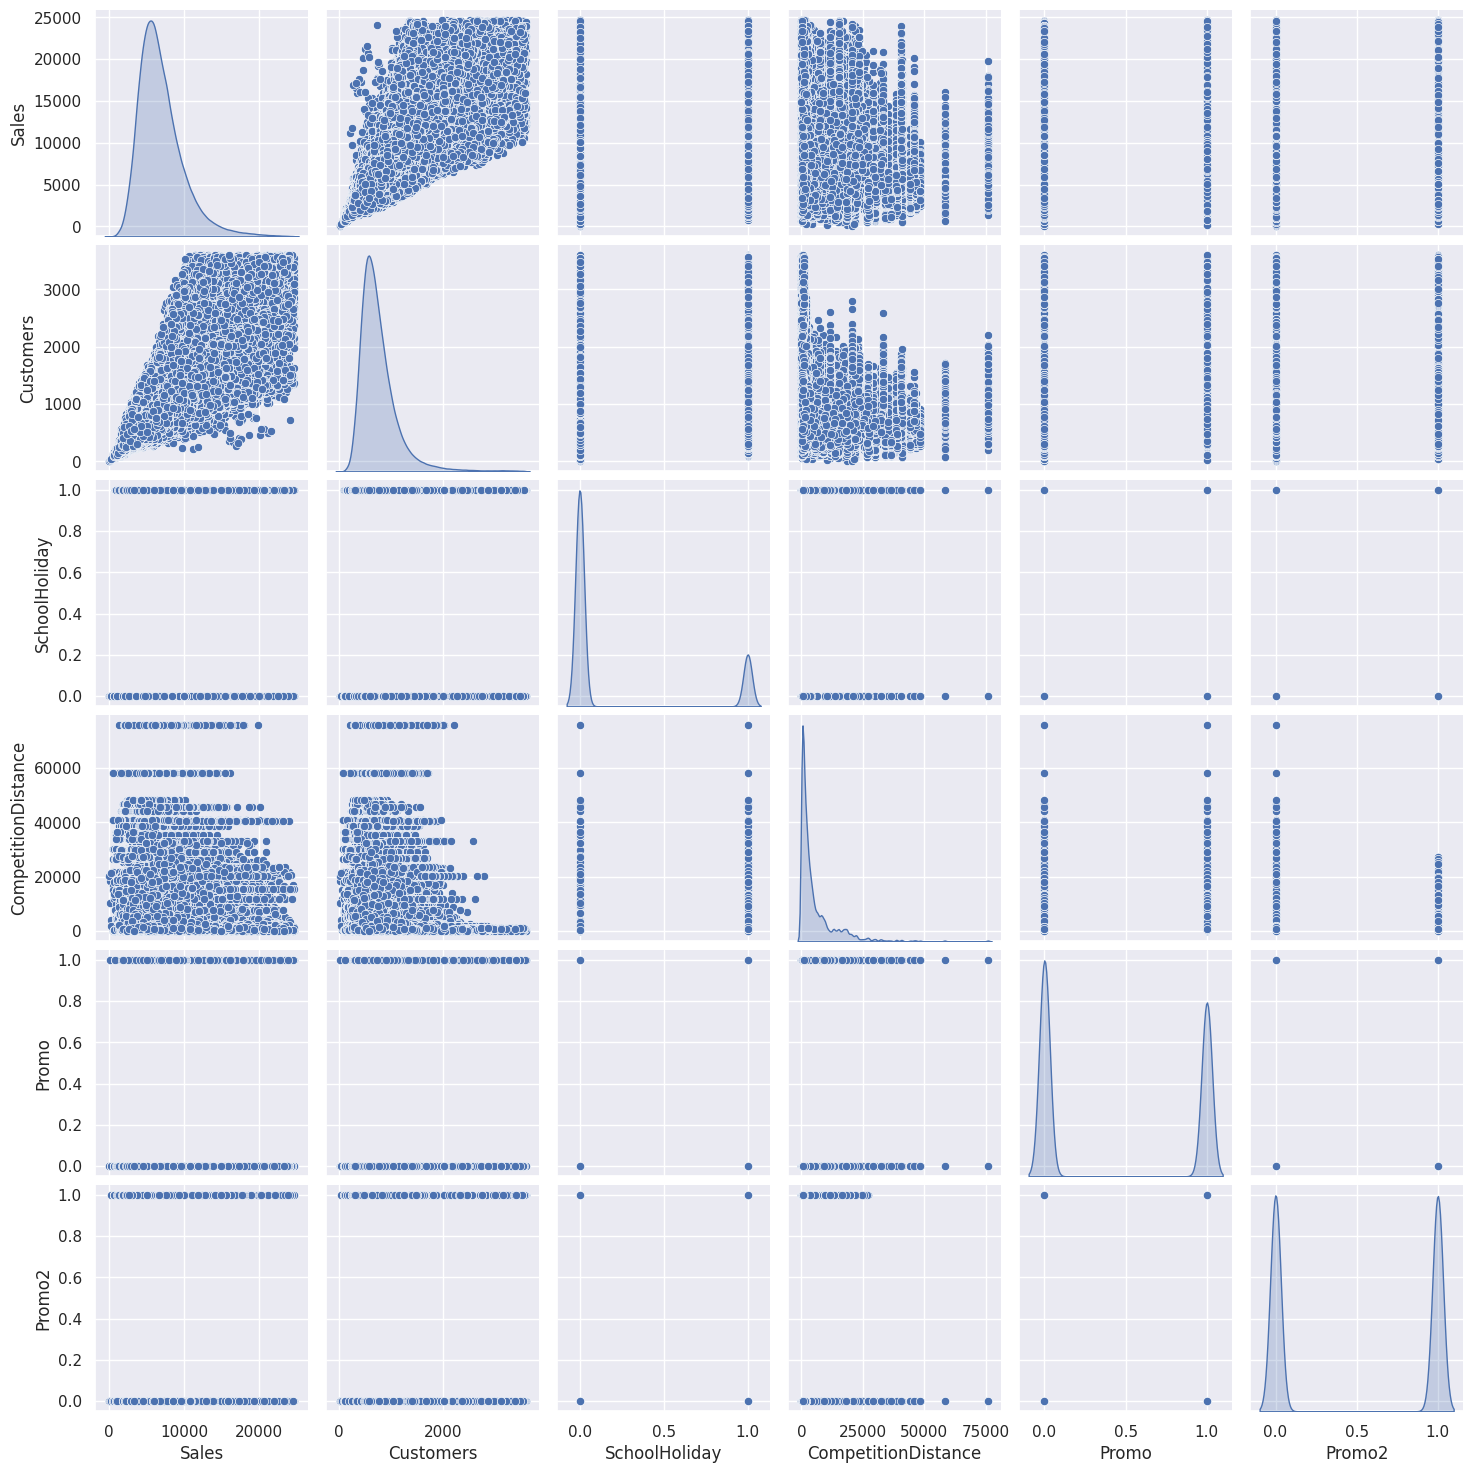

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
data_pair_df = train_merge_store_df[['Sales','Customers','StateHoliday','SchoolHoliday','StoreType','CompetitionDistance','Promo','Promo2']]
sns.pairplot(data_pair_df, diag_kind='kde')   
# to plot density curve instead of the histogram on the diagram # Kernel density estimation(kde)

### t-SNE using Scikit-Learn
#### Observation: based on below t-SNE
*   Perplexity 30 spread the Sales wider, and more groups
*   Perplexity 50 spread the Sales closer, and lesser groups

In [ ]:
data_y = train_merge_store_df['Sales']
data_X = train_merge_store_df.drop(['Store','Sales','Date','Open'], axis=1)

In [ ]:
sample_data_y = data_y.sample(n=5000, random_state=42)
sample_data_X = data_X.sample(n=5000, random_state=42)
print("the shape of sample data = ", sample_data_X.shape)

the shape of sample data =  (5000, 17)


In [ ]:
# Data-preprocessing: Standardizing the data
std_sample_data = StandardScaler().fit_transform(sample_data_X)
print("the shape of standardized sample data = ", std_sample_data.shape)

the shape of standardized sample data =  (5000, 17)


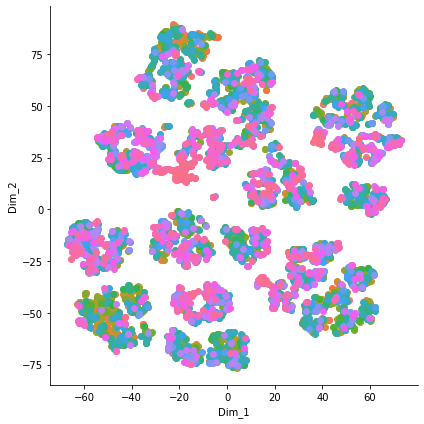

In [ ]:
#this is with perplexity 30
xtsne=TSNE(perplexity=30, random_state=0)
results=xtsne.fit_transform(std_sample_data)
vis_x = results[:, 0]
vis_y = results[:, 1]
tsne_df = pd.DataFrame(data=np.column_stack((results, sample_data_y)), columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2')#.add_legend()
plt.show()

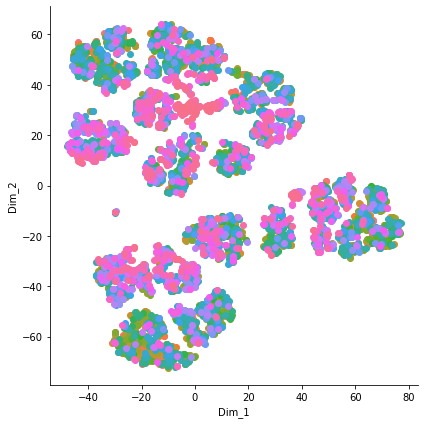

In [ ]:
#this is with perplexity 50
xtsne=TSNE(perplexity=50, random_state=0)
results=xtsne.fit_transform(std_sample_data)
vis_x = results[:, 0]
vis_y = results[:, 1]
tsne_df = pd.DataFrame(data=np.column_stack((results, sample_data_y)), columns=("Dim_1", "Dim_2", "label"))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2')#.add_legend()
plt.show()

### PCA using Scikit-Learn
#### Observations: based on below PCA method
*   More than 90% of the variance is explained by 10 features
*   Principal Component 1 is explained about the sales with less variance
*   Principal Component21 is explained about the sales with little more variance

In [ ]:
# initializing the pca
pca = decomposition.PCA()

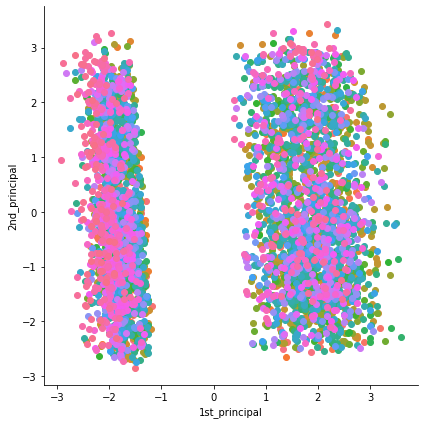

In [ ]:
# configuring the parameteres
# the number of components = 2
pca.n_components = 2
pca_data = pca.fit_transform(std_sample_data)

# attaching the label for each 2-d data point 
pca_data = np.vstack((pca_data.T, sample_data_y)).T

# creating a new data fram which help us in ploting the result data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "label"))
sns.FacetGrid(pca_df, hue="label", size=6).map(plt.scatter, '1st_principal', '2nd_principal')#.add_legend()
plt.show()

In [ ]:
pc_comps = ['PC1','PC2','PC3']
data_pca = pd.DataFrame(np.round(pca.components_[:3,:],2),index=pc_comps,columns=sample_data_X.columns)
data_pca.T

,PC1,PC2,PC3
DayOfWeek,0.01,-0.06,-0.04
Customers,-0.12,0.05,-0.01
Promo,-0.01,0.03,0.02
StateHoliday,-0.00,-0.02,0.02
SchoolHoliday,-0.00,0.13,0.05
StoreType,0.06,-0.02,0.18
Assortment,0.01,0.02,0.24
CompetitionDistance,-0.11,-0.02,0.14
CompetitionOpenSinceMonth,-0.09,-0.02,-0.66
CompetitionOpenSinceYear,-0.11,-0.02,-0.66


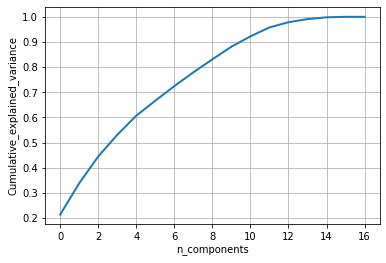

In [ ]:
# PCA for dimensionality redcution (non-visualization)
pca.n_components = 17
pca_data = pca.fit_transform(std_sample_data)

percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

# If we take 200-dimensions, approx. 90% of variance is expalined.

##### Finding Correlation between Features

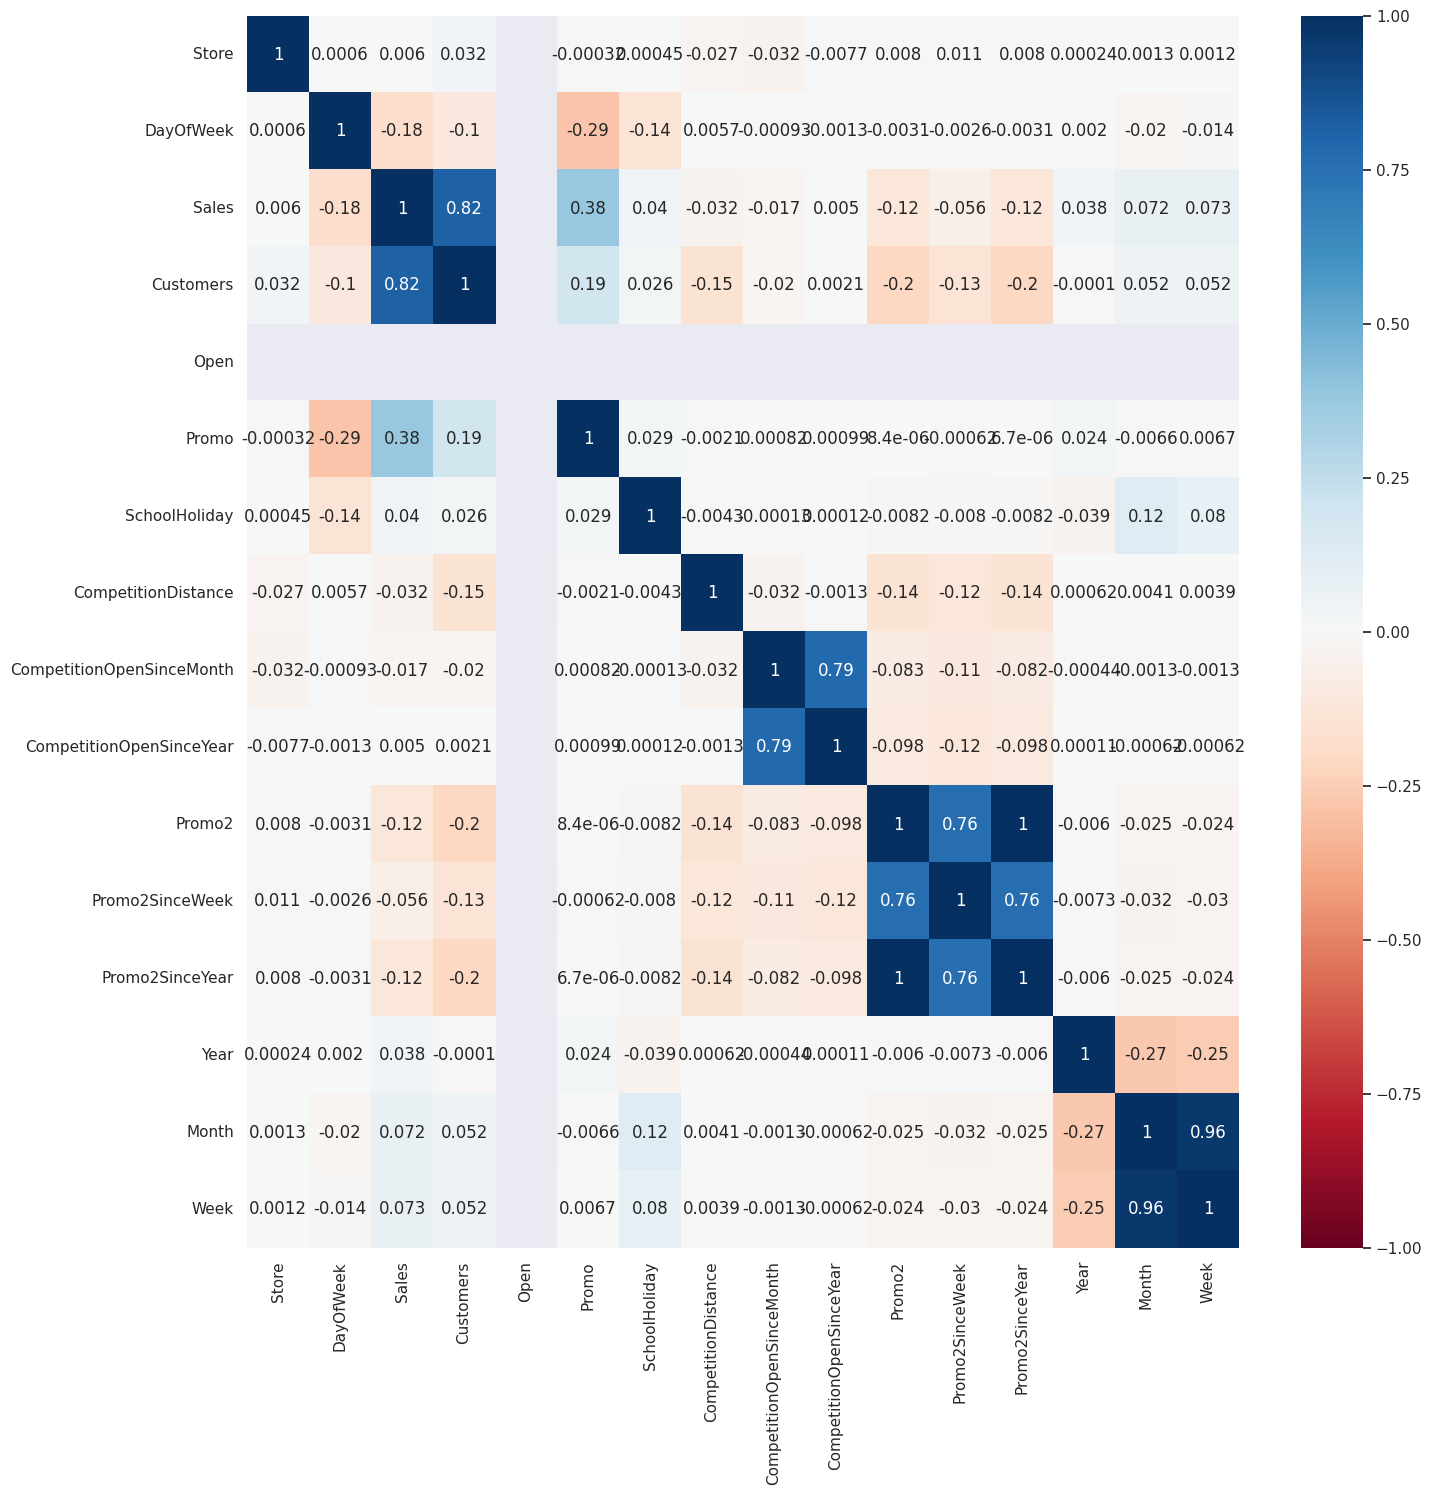

In [ ]:
plt.figure(figsize = (16,16))
# plotting correlation heatmap
dataplot = sns.heatmap(train_merge_store_df.corr(), cmap='RdBu', vmin=-1, vmax=1, annot=True)
#more parameters annot_kws={'fontsize':11, 'fontweight':'bold'}, square=True
 
# displaying heatmap
plt.show()

### EDA - After merging Train and Store data

*   Sales is more for StoreType 'b'. Average Sales also more for StoreType 'b'.
*   Sales is more for Assortment 'b'. Average Sale also more for StoreType 'b'.
*   With or Without Promo2, aroung 13% difference in Average sales. With Promo2, Average Sales is more.
*   Average Sales increases from 2013 to 2015, we have significant improvement in 2015 (we have data till July 31st).
*   Sales and Customer features have some considerable Correlation (.89).
*   Sales and Open features have some Correlation (.68).
*   Sales and Promo features have some Correlation (0.45).
*   Correlation between DayOfWeek and Sales/Customers/Open/Promo is negative. features have some considerable Correlation
*   CompetitionDistance is null for 3 Stores, can be considered as no competetors for those 3 stores. Replace nan with mean value of CompetitionDistance.


<font color="red">Reading test data</font>

In [18]:
#Read the test dataset
test_df = pd.read_csv(r"test.csv")

#check the info of the dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


#### <font color="red">Removing rows (11) with Open as NaN/null.</font>

In [19]:
test_df = test_df.dropna(axis=0)

In [ ]:
test_df.info()
#Comparing wiht test, extra Id, no Sales, no Customers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41077 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41077 non-null  int64  
 1   Store          41077 non-null  int64  
 2   DayOfWeek      41077 non-null  int64  
 3   Date           41077 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41077 non-null  int64  
 6   StateHoliday   41077 non-null  object 
 7   SchoolHoliday  41077 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.8+ MB


In [ ]:
test_df['Id']

0            1
1            2
2            3
3            4
4            5
         ...  
41083    41084
41084    41085
41085    41086
41086    41087
41087    41088
Name: Id, Length: 41077, dtype: int64

In [ ]:
min(test_df['Date']), max(test_df['Date'])

('2015-08-01', '2015-09-17')

### EDA - Test Data Analysis

*   A unique Id for each row in test data set (1 to 41088).
*   Found around 11 rows having null value in Open column.
*   Task is to forecast Sales from 1st Aug 2015 to 17th Sep 2015.

# **Data Cleansing/Pre-Processing**

#### Below Activities Done part of Above Steps
*   Remove rows where Sales has NaN/null. 
*   Remove Outliers in Sales - 99.9 percentile of data and after which is >= 24680.
*   Remove Outliers in Customers - 99.9 percentile of data and after which is >= 3600.
*   StateHoliday column contains two different values 0 (count=131072) and '0' (count=855087), so replaced 0 with '0' for that data.
*   Replace CompetitionDistance of null/NaN with median (2325) of CompetitionDistance.
*   Replace NaN/null values in CompetitionOpenSinceYear, CompetitionOpenSinceMonth, Promo2SinceYear, Promo2SinceWeek, PromoInterval with 0.
*   Converting Date feature dtype from 'object' to 'datetime64[ns]' to extract features from it.
*   Sorting the Train Data by Date.

# **Featurization**
Including Existing Features
*   Store
*   DayOfWeek
*   Sales
*   StoreType
*   Assortment
*   StateHoliday
*   PromoInterval
*   Customers
*   SchoolHoliday
*   CompetitionDistance
*   CompetitionOpenSinceYear
*   CompetitionOpenSinceMonth
*   Promo
*   Promo2
*   Promo2SinceYear
*   Promo2SinceWeek

Adding New Feature(s)
*   Encoding StoreType, Assortment, StateHoliday, PromoInterval categorical features.
*   Year – Extracted from Date feature.
*   Month - Extracted from Date feature.
*   Day - Extracted from Date feature.
*   AvgCustSpentOnDay – On a given day in data, Sales/# of Customers visited that day that store.
*   AvgSalesPerStore – Average Sales per store, Extracted from Sales feature.
*   AvgCustomersPerStore – Average Customers visited a Store; Extracted from Customers feature.
*   PerCentDiseaseAffInWeek – Find data on Diseases affect in Europe countries in google, using Date feature, find Year and Week. Based on the data provided the % of positive tests, enter the value in this feature, ranges from (0 to 100). Please refer Data Preparation in above steps.

Adding Temporary Feature(s)
*   Year-Week – Concatenated from Year and Week separated by ‘-‘.

Removing Existing/Temporay Feature(s)
*   Date
*   Open
*   Year-Week


##### <font color="red">Features Year, Month, Week already added as part above steps.</font>

In [20]:
train_merge_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842936 entries, 842935 to 0
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      842936 non-null  int64         
 1   DayOfWeek                  842936 non-null  int64         
 2   Date                       842936 non-null  datetime64[ns]
 3   Sales                      842936 non-null  int64         
 4   Customers                  842936 non-null  int64         
 5   Open                       842936 non-null  int64         
 6   Promo                      842936 non-null  int64         
 7   StateHoliday               842936 non-null  object        
 8   SchoolHoliday              842936 non-null  int64         
 9   StoreType                  842936 non-null  object        
 10  Assortment                 842936 non-null  object        
 11  CompetitionDistance        842936 non-null  float64 

##### <font color="red">Creating new Feature 'PerCentDiseaseAffInWeek'.</font>
Data Preparation is mentioned in the assignment doc.

In [ ]:
# Way to upload file into google colab # Takes time if file size exceeds 200 mb
# e.g., 9 Mb file took 3.20 min
from google.colab import files
files.upload()

In [22]:
#Read the disease_week dataset
disease_week_df = pd.read_csv(r"DiseaseAffWeek.csv")#, index_col='Date', parse_dates=True)

#check the info of the dataset
disease_week_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Year-Week                157 non-null    object
 1   PerCentDiseaseAffInWeek  157 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.6+ KB


In [23]:
# Timetaken for this step: around 30 - 120 sec
train_merge_store_df['Year-Week'] = train_merge_store_df.apply(lambda row: str(row.Year) +"-"+ str(row.Week), axis=1)

In [ ]:
max(train_merge_store_df['Week'][train_merge_store_df['Year']==2015])

31

In [24]:
train_merge_store_df = pd.merge(train_merge_store_df, disease_week_df, on='Year-Week', how='left')

##### <font color="red">Encoding StoreType, Assortment, StateHoliday, PromoInterval categorical Features.</font>


In [25]:
train_merge_store_df['StoreType'] = train_merge_store_df['StoreType'].astype('category').cat.codes
train_merge_store_df['Assortment'] = train_merge_store_df['Assortment'].astype('category').cat.codes
train_merge_store_df['StateHoliday'] = train_merge_store_df['StateHoliday'].astype('category').cat.codes
train_merge_store_df['PromoInterval'] = train_merge_store_df['PromoInterval'].astype('category').cat.codes

##### <font color="red">Creating new Features AvgSalesPerStore, AvgCustomersPerStore.</font>

In [26]:
train_avg_per_store = train_merge_store_df.groupby('Store')[['Sales', 'Customers']].mean()
train_avg_per_store.head(2)

,Sales,Customers
Store,,
1,4759.096031,564.049936
2,4953.900510,583.998724


In [27]:
train_avg_per_store.rename(columns=lambda x: 'Avg'+ x +'PerStore', inplace=True)
train_avg_per_store.head(2)

,AvgSalesPerStore,AvgCustomersPerStore
Store,,
1,4759.096031,564.049936
2,4953.900510,583.998724


In [28]:
train_merge_store_df = pd.merge(train_merge_store_df, train_avg_per_store.reset_index(), on='Store', how='left')

##### <font color="red">Creating new Features MedSalesPerStore, MedCustomersPerStore.</font>

In [29]:
train_med_per_store = train_merge_store_df.groupby('Store')[['Sales', 'Customers']].median()
train_med_per_store.head(2)

,Sales,Customers
Store,,
1,4647.0,550.0
2,4783.0,575.5


In [30]:
train_med_per_store.rename(columns=lambda x: 'Med'+ x +'PerStore', inplace=True)
train_med_per_store.head(2)

,MedSalesPerStore,MedCustomersPerStore
Store,,
1,4647.0,550.0
2,4783.0,575.5


In [31]:
train_merge_store_df = pd.merge(train_merge_store_df, train_med_per_store.reset_index(), on='Store', how='left')

##### <font color="red">Creating new Feature 'AvgCustSpentInStore'.</font>

In [32]:
train_avg_cust_spent_store = train_merge_store_df.groupby('Store')[['Sales', 'Customers']].sum()
train_avg_cust_spent_store.head(2)

,Sales,Customers
Store,,
1,3716854,440523
2,3883858,457855


In [33]:
train_avg_cust_spent_store.rename(columns=lambda x: 'Total'+ x +'PerStore', inplace=True)
train_avg_cust_spent_store.head(2)

,TotalSalesPerStore,TotalCustomersPerStore
Store,,
1,3716854,440523
2,3883858,457855


In [34]:
train_avg_cust_spent_store['AvgCustSpentInStore'] = train_avg_cust_spent_store['TotalSalesPerStore'] / train_avg_cust_spent_store['TotalCustomersPerStore']

In [35]:
train_merge_store_df = pd.merge(train_merge_store_df, train_avg_cust_spent_store.reset_index(), on='Store', how='left')

##### <font color="red">Creating Features 'LastWeekSalesPerStore', 'LastWeekCustomersPerStore'.</font>

In [36]:
train_last_cust_spent_store = train_merge_store_df[train_merge_store_df['Year-Week'] == '2015-31'].groupby('Store')[['Sales', 'Customers']].sum()
train_last_cust_spent_store.head(2)

,Sales,Customers
Store,,
1,26178,2796
2,30331,3237


In [37]:
train_last_cust_spent_store.rename(columns=lambda x: 'LastWeek'+ x +'PerStore', inplace=True)
train_last_cust_spent_store.head(2)

,LastWeekSalesPerStore,LastWeekCustomersPerStore
Store,,
1,26178,2796
2,30331,3237


In [38]:
train_merge_store_df = pd.merge(train_merge_store_df, train_last_cust_spent_store.reset_index(), on='Store', how='left')

In [39]:
train_merge_store_df["LastWeekSalesPerStore"][train_merge_store_df.LastWeekSalesPerStore.isnull()] = train_merge_store_df['LastWeekSalesPerStore'].median()
train_merge_store_df["LastWeekCustomersPerStore"][train_merge_store_df.LastWeekCustomersPerStore.isnull()] = train_merge_store_df['LastWeekCustomersPerStore'].median()

##### <font color="red">Dropping Features 'Date', 'Open', and 'Customers'.</font>

In [40]:
train_merge_store_df = train_merge_store_df.drop(['Date','Open','Customers'], axis=1)

##### <font color="red">Dropping Features created for temporarily 'Year-Week'.</font>

In [41]:
train_merge_store_df = train_merge_store_df.drop(['Year-Week','TotalSalesPerStore','TotalCustomersPerStore'], axis=1)

### <font color="red">train_merge_store_df: Finalized Features in train data.</font>

In [42]:
train_merge_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 842936 entries, 0 to 842935
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      842936 non-null  int64  
 1   DayOfWeek                  842936 non-null  int64  
 2   Sales                      842936 non-null  int64  
 3   Promo                      842936 non-null  int64  
 4   StateHoliday               842936 non-null  int8   
 5   SchoolHoliday              842936 non-null  int64  
 6   StoreType                  842936 non-null  int8   
 7   Assortment                 842936 non-null  int8   
 8   CompetitionDistance        842936 non-null  float64
 9   CompetitionOpenSinceMonth  842936 non-null  float64
 10  CompetitionOpenSinceYear   842936 non-null  float64
 11  Promo2                     842936 non-null  int64  
 12  Promo2SinceWeek            842936 non-null  float64
 13  Promo2SinceYear            84

In [43]:
train_merge_store_df.head(2)

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,...,Month,Week,PerCentDiseaseAffInWeek,AvgSalesPerStore,AvgCustomersPerStore,MedSalesPerStore,MedCustomersPerStore,AvgCustSpentInStore,LastWeekSalesPerStore,LastWeekCustomersPerStore
0,1097,2,5961,0,1,1,1,1,720.0,3.0,...,1,1,45,9737.629118,2419.451647,9599.0,2460.0,4.024726,52919.0,11784.0
1,85,2,4220,0,1,1,1,0,1870.0,10.0,...,1,1,45,7272.454352,1015.401274,6622.0,929.5,7.162148,38018.0,4736.0


#### <font color="red">Merging test data with store store data preparing the features as in train_merge_store.</font>

In [44]:
test_merge_store_df = pd.merge(test_df, store_df, on='Store', how='left')

In [ ]:
test_merge_store_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41077 entries, 0 to 41076
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41077 non-null  int64  
 1   Store                      41077 non-null  int64  
 2   DayOfWeek                  41077 non-null  int64  
 3   Date                       41077 non-null  object 
 4   Open                       41077 non-null  float64
 5   Promo                      41077 non-null  int64  
 6   StateHoliday               41077 non-null  object 
 7   SchoolHoliday              41077 non-null  int64  
 8   StoreType                  41077 non-null  object 
 9   Assortment                 41077 non-null  object 
 10  CompetitionDistance        41077 non-null  float64
 11  CompetitionOpenSinceMonth  41077 non-null  float64
 12  CompetitionOpenSinceYear   41077 non-null  float64
 13  Promo2                     41077 non-null  int

##### <font color="red">test_merge_store_df: Adding belew new features based on Feature Date.</font>
*   Year
*   Month
*   Week

###### Converting Date feature dtype from 'object' to 'datetime64[ns]' to extract features from it

In [45]:
test_merge_store_df['Date'] = pd.to_datetime(test_merge_store_df['Date'], errors='coerce')

In [46]:
test_merge_store_df['Year'] = test_merge_store_df.Date.dt.year
test_merge_store_df['Month'] = test_merge_store_df.Date.dt.month
test_merge_store_df['Week'] = test_merge_store_df.Date.dt.week

##### <font color="red">test_merge_store: Sorting test Data by Date</font>

In [47]:
test_merge_store_df = test_merge_store_df.sort_values(by='Date')

##### <font color="red">Creating new Feature 'PerCentDiseaseAffInWeek'.</font>
Data Preparation is mentioned in the assignment doc.

In [48]:
# Timetaken for this step: around 5 sec
test_merge_store_df['Year-Week'] = test_merge_store_df.apply(lambda row: str(row.Year) +"-"+ str(row.Week), axis=1)

In [49]:
test_merge_store_df = pd.merge(test_merge_store_df, disease_week_df, on='Year-Week', how='left')

##### <font color="red">Encoding StoreType, Assortment, StateHoliday, PromoInterval categorical Features.</font>


In [50]:
test_merge_store_df['StoreType'] = test_merge_store_df['StoreType'].astype('category').cat.codes
test_merge_store_df['Assortment'] = test_merge_store_df['Assortment'].astype('category').cat.codes
test_merge_store_df['StateHoliday'] = test_merge_store_df['StateHoliday'].astype('category').cat.codes
test_merge_store_df['PromoInterval'] = test_merge_store_df['PromoInterval'].astype('category').cat.codes

##### <font color="red">Creating new Features AvgSalesPerStore, AvgCustomersPerStore.</font>

In [51]:
test_merge_store_df = pd.merge(test_merge_store_df, train_avg_per_store.reset_index(), on='Store', how='left')

##### <font color="red">Creating new Features MedSalesPerStore, MedCustomersPerStore.</font>

In [52]:
test_merge_store_df = pd.merge(test_merge_store_df, train_med_per_store.reset_index(), on='Store', how='left')

##### <font color="red">test_merge_store_df: Creating new Feature 'AvgCustSpentInStore'.</font>

In [53]:
test_merge_store_df = pd.merge(test_merge_store_df, train_avg_cust_spent_store.reset_index(), on='Store', how='left')

##### <font color="red">test_merge_store_df: Creating Features 'LastWeekSalesPerStore', 'LastWeekCustomersPerStore'.</font>

In [54]:
test_merge_store_df = pd.merge(test_merge_store_df, train_last_cust_spent_store.reset_index(), on='Store', how='left')

In [55]:
test_merge_store_df["LastWeekSalesPerStore"][test_merge_store_df.LastWeekSalesPerStore.isnull()] = test_merge_store_df['LastWeekSalesPerStore'].median()
test_merge_store_df["LastWeekCustomersPerStore"][test_merge_store_df.LastWeekCustomersPerStore.isnull()] = test_merge_store_df['LastWeekCustomersPerStore'].median()

##### <font color="red">Dropping Features 'Id', 'Date' and 'Open'.</font>

In [56]:
test_merge_store_df = test_merge_store_df.drop(['Id','Date','Open'], axis=1)

##### <font color="red">Dropping Features created for temporarily 'Year-Week', 'TotalSalesPerStore' and 'TotalCustomersPerStore'.</font>

In [57]:
test_merge_store_df = test_merge_store_df.drop(['Year-Week','TotalSalesPerStore','TotalCustomersPerStore'], axis=1)

### <font color="red">test_merge_store_df: Finalized Features in test data.</font>

In [58]:
test_merge_store_df.info()
#Sales, Customers, AvgCustSpentOnDay , extra Id

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41077 entries, 0 to 41076
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      41077 non-null  int64  
 1   DayOfWeek                  41077 non-null  int64  
 2   Promo                      41077 non-null  int64  
 3   StateHoliday               41077 non-null  int8   
 4   SchoolHoliday              41077 non-null  int64  
 5   StoreType                  41077 non-null  int8   
 6   Assortment                 41077 non-null  int8   
 7   CompetitionDistance        41077 non-null  float64
 8   CompetitionOpenSinceMonth  41077 non-null  float64
 9   CompetitionOpenSinceYear   41077 non-null  float64
 10  Promo2                     41077 non-null  int64  
 11  Promo2SinceWeek            41077 non-null  float64
 12  Promo2SinceYear            41077 non-null  float64
 13  PromoInterval              41077 non-null  int

In [59]:
test_merge_store_df.head(2)

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,...,Month,Week,PerCentDiseaseAffInWeek,AvgSalesPerStore,AvgCustomersPerStore,MedSalesPerStore,MedCustomersPerStore,AvgCustSpentInStore,LastWeekSalesPerStore,LastWeekCustomersPerStore
0,1115,6,0,0,1,3,2,5350.0,0.0,0.0,...,8,31,2,6302.469910,432.629962,6126.0,426.0,14.567807,43551,2621
1,378,6,0,0,0,0,2,2140.0,8.0,2012.0,...,8,31,2,6324.801027,970.156611,5994.0,946.0,6.519361,40078,5485


##### <font color="red">Getting column names from test data in the order, so we can follow same columns order in the train data in next cell.</font>

In [60]:
test_columns_list = test_merge_store_df.columns.tolist()

# **Train and Test data split**

In [61]:
y = train_merge_store_df['Sales']
# instead of dropping choosing columns to make sure train and test data have same sequence of columns.drop(['Sales'], axis=1)
X = train_merge_store_df[test_columns_list] 

In [62]:
# Performing split on the dataset into Train, Validation and Test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, random_state=33)
print("Train data shape: ", X_train.shape, y_train.shape)
#print("Validation data shape: ", X_cv.shape, y_cv.shape)
print("Test data shape: ", X_test.shape, y_test.shape)

Train data shape:  (674348, 25) (674348,)
Test data shape:  (168588, 25) (168588,)


In [88]:
def rmspe(y_true, y_pred):
    return (np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100)

# **Modelling: Baseline Models**

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [70]:
df1=train_df.sort_values(by='Date')

In [ ]:
df1.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017190,1097,2,2013-01-01,5961,1405,1,0,a,1
1016179,85,2,2013-01-01,4220,619,1,0,a,1
1016353,259,2,2013-01-01,6851,1444,1,0,a,1
1016356,262,2,2013-01-01,17267,2875,1,0,a,1
1016368,274,2,2013-01-01,3102,729,1,0,a,1


In [ ]:
"""Simple Moving Average (SMA) - Hyper-Parameter (window_size) Tuning"""
# Ref: https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
X = df1['Sales'].values # Storing only Sales data in Data ascending order.
window_sizes = [1, 3, 5, 10, 20, 50, 100]
sma_mse_lst = []
for window in window_sizes:
    # Below: Getting training data with window size
    ma_train = [X[i] for i in range(window)] 
    # Below: Getting testing data except the data of window size from begining; This is going to be true/observed data
    ma_test = [X[i] for i in range(window, len(X))]
    predictions = list() # To store predicted sma from train train data
    #Below for: moving forward one time step in ma_test at each iteration
    for t in range(len(ma_test)): 
        length = len(ma_train)
        # Below: Calculating/predicting sma using data collected in training data(ma_train)
        yhat = round(mean([ma_train[i] for i in range(length-window,length)]), 3) 
        predictions.append(yhat)
        obs = ma_test[t]
        ma_train.append(obs) # Increasing Train data by adding one more element 
    mse = mean_squared_error(ma_test, predictions) #MSE 
    sma_mse_lst.append(mse)
print(sma_mse_lst)

[13729921.50233648, 9301584.756824337, 8319977.169573688, 7525221.489137043, 7185884.91250054, 6989407.855436673, 6961802.240281353]


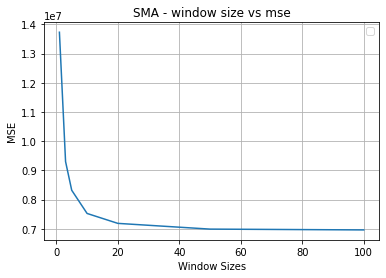

In [ ]:
plt.plot(window_sizes, sma_mse_lst)
plt.legend()
plt.xlabel("Window Sizes")
plt.ylabel("MSE")
plt.title("SMA - window size vs mse")
plt.grid()
plt.show()

##### Observations from above graph based on training for SMA, found best parameter as below:
*   window = 50

In [91]:
"""Simple Moving Average (SMA) - Finding RMSE for Best Parameter"""
# Ref: https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
X = df1['Sales'].values # Storing only Sales data in Data ascending order.
window = 50
# Below: Getting training data with window size
ma_train = [X[i] for i in range(window)] 
# Below: Getting testing data except the data of window size from begining; This is going to be true/observed data
ma_test = [X[i] for i in range(window, len(X))]
predictions = list() # To store predicted sma from train train data
#Below for: moving forward one time step in ma_test at each iteration
for t in range(len(ma_test)): 
    length = len(ma_train)
    # Below: Calculating/predicting sma using data collected in training data(ma_train)
    yhat = round(mean([ma_train[i] for i in range(length-window,length)]), 3) 
    predictions.append(yhat)
    obs = ma_test[t]
    ma_train.append(obs) # Increasing Train data by adding one more element 
ma_test_arr = np.array(ma_test)
predictions_arr = np.array(predictions)
sma_rmspe_score = rmspe(ma_test_arr, predictions_arr) #RMSPE 
print("sma_rmspe_score: ", sma_rmspe_score)

sma_rmspe_score:  51.681060257327104


In [71]:
"""Finding the SMA for the test data given in the Case Study with window size = 50 found through tuning"""
X = df1['Sales'].values
y_sma_test_pred = []
window = 50
ma_train = [X[i] for i in range(window)]
ma_test = [X[i] for i in range(window, len(X))]
predictions = list()
for t in range(len(X)+len(test_df)-window):
    length = len(ma_train)
    yhat = round(mean([ma_train[i] for i in range(length-window,length)]), 3)
    if t >= (len(X)-window):
        y_sma_test_pred.append(yhat) #Storing sma prediciton for only test data.
        ma_train.append(yhat)
        ma_test.append(yhat)
    else:
        obs = ma_test[t]
        ma_train.append(obs)
sma_mse = mean_squared_error(ma_test, predictions) #MSE 

In [97]:
# Best Parameter with rmspe_score
sma_window = 50
sma_rmspe_score = 51.68

In [ ]:
y_sma_test_pred[:10]

[8986.7,
 8937.454,
 8999.223,
 9008.268,
 9063.073,
 9171.374,
 9060.202,
 8989.006,
 9012.846,
 8913.323]

### Weighted Moving Averages
The Moving Avergaes Model used gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones<br>

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [ ]:
"""Weghted Moving Average (WMA) - Hyper-Parameter (window_size) Tuning"""
X = df1['Sales'].values # Storing only Sales data in Data ascending order.
window_sizes = [1, 3, 5, 10, 20, 50, 100]
wma_mse_lst = []
for window in window_sizes:
    ma_train = [X[i] for i in range(window)]
    ma_test = [X[i] for i in range(window, len(X))]
    predictions = list()
    # walk forward over time steps in ma_test
    for t in range(len(ma_test)):
        length = len(ma_train)
        sum_values=0
        sum_of_coeff=0
        for j in range(window,0,-1):
            sum_values += j*(ma_train[length-1]) #Weighted sum is getting calculated
            length -= 1                 
            sum_of_coeff += j #for Calulating (N*(N+1))/2 which Sum of N number formula
        yhat = round(sum_values/sum_of_coeff, 3)
        predictions.append(yhat)
        obs = ma_test[t]
        ma_train.append(obs)
    mse = mean_squared_error(ma_test, predictions)
    wma_mse_lst.append(mse)

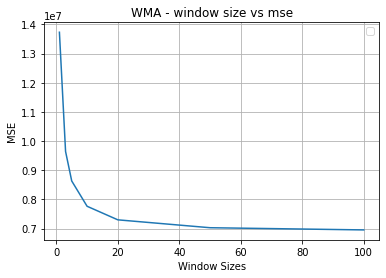

In [ ]:
plt.plot(window_sizes, wma_mse_lst)
plt.legend()
plt.xlabel("Window Sizes")
plt.ylabel("MSE")
plt.title("WMA - window size vs mse")
plt.grid()
plt.show()

##### Observations from above graph based on training for WMA, found best parameter as below:
*   window = 50

In [93]:
"""Weghted Moving Average (WMA) - Finding RMSPE with best parameter"""
X = df1['Sales'].values # Storing only Sales data in Data ascending order.
window = 50
ma_train = [X[i] for i in range(window)]
ma_test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in ma_test
for t in range(len(ma_test)):
    length = len(ma_train)
    sum_values=0
    sum_of_coeff=0
    for j in range(window,0,-1):
        sum_values += j*(ma_train[length-1]) #Weighted sum is getting calculated
        length -= 1                 
        sum_of_coeff += j #for Calulating (N*(N+1))/2 which Sum of N number formula
    yhat = round(sum_values/sum_of_coeff, 3)
    predictions.append(yhat)
    obs = ma_test[t]
    ma_train.append(obs)
ma_test_arr = np.array(ma_test)
predictions_arr = np.array(predictions)
wma_rmspe_score = rmspe(ma_test_arr, predictions_arr) #RMSPE 
print("wma_rmspe_score: ", wma_rmspe_score)

wma_rmspe_score:  51.96350614699621


In [ ]:
"""Best window size found from above graph"""
window = 50
X = df1['Sales'].values # Storing only Sales data in Data ascending order.
y_wma_test_pred = []
ma_train = [X[i] for i in range(window)]
ma_test = [X[i] for i in range(window, len(X))]
predictions = list()
for t in range(len(X)+len(test_df)-window): # walk forward over time steps in ma_test
    length = len(ma_train)
    sum_values = 0
    sum_of_coeff = 0
    for j in range(window,0,-1):
        sum_values += j*(ma_train[length-1])
        length -= 1                 
        sum_of_coeff+=j
    yhat = round(sum_values/sum_of_coeff, 3)
    if t >= (len(X)-window):
        y_wma_test_pred.append(yhat)
        ma_train.append(yhat)
        ma_test.append(yhat)
    else:
        obs = ma_test[t]
        ma_train.append(obs)        

In [96]:
# Best Parameter with rmspe_score
wma_window = 50
wma_rmspe_score = 51.96

In [ ]:
y_wma_test_pred[:10]

[8840.838,
 8835.118,
 8831.22,
 8824.826,
 8817.959,
 8808.817,
 8795.261,
 8785.818,
 8779.005,
 8771.149]

### Exponential  Weighted Moving Averages
 https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

In [ ]:
"""Exponential Weighted Moving Average (EWMA) - Hyper-Parameters 
(window_size, alpha(smoothing factor, range 0 to 1) Tuning"""
# Time taken ~ <5 min
X = df1['Sales'].values 
window_sizes = [1, 3, 5, 10, 20, 50, 100] # various window size
smoohing_factor = [0.1, 0.3, 0.5, 0.7, 0.9] # various smoothin factors
ewma_mse_df = pd.DataFrame()
for window in window_sizes:
    ewma_mse_lst = []
    for alpha in smoohing_factor:
        ma_train = [X[i] for i in range(window)]
        ma_test = [X[i] for i in range(window, len(X))]
        predictions = list()
        for t in range(len(ma_test)): # walk forward over time steps in ma_test
            length = len(ma_train)
            if t == 0:
                predictions.append(0)
            else:
                yhat = round((alpha*ma_train[length-1]) + (1-alpha)*predictions[-1], 2)
                predictions.append(yhat)
            obs = ma_test[t]
            ma_train.append(obs)
        mse = round(mean_squared_error(ma_test, predictions), 3)
        ewma_mse_lst.append(mse)
    ewma_mse_df[window] = ewma_mse_lst

In [ ]:
ewma_mse_df.head()

,1,3,5,10,20,50,100
0,7.231573e+06,7.231597e+06,7.231360e+06,7.231390e+06,7.231454e+06,7.231278e+06,7.231377e+06
1,8.133010e+06,8.133060e+06,8.132764e+06,8.132773e+06,8.132807e+06,8.132679e+06,8.132839e+06
2,9.224212e+06,9.224301e+06,9.223947e+06,9.223949e+06,9.223974e+06,9.223842e+06,9.224055e+06
3,1.061826e+07,1.061839e+07,1.061797e+07,1.061797e+07,1.061799e+07,1.061785e+07,1.061811e+07
4,1.250524e+07,1.250544e+07,1.250493e+07,1.250493e+07,1.250496e+07,1.250480e+07,1.250511e+07


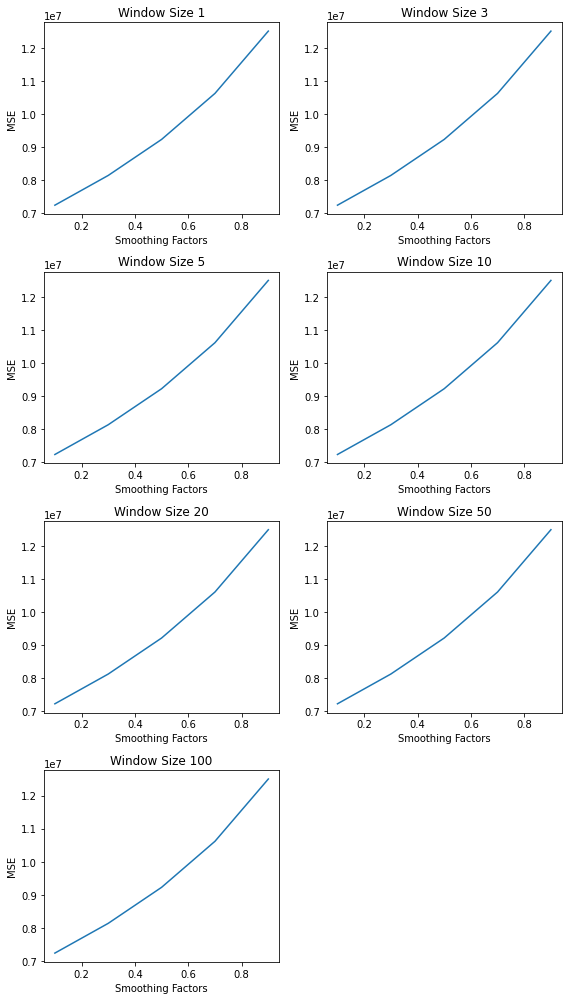

In [ ]:
f,axarr = plt.subplots(4, 2, figsize=(8, 14))

axarr[0,0].plot(smoohing_factor, ewma_mse_df[1])
axarr[0,0].set_xlabel("Smoothing Factors")
axarr[0,0].set_ylabel("MSE")
axarr[0,0].set_title('Window Size 1')

axarr[0,1].plot(smoohing_factor, ewma_mse_df[3])
axarr[0,1].set_xlabel("Smoothing Factors")
axarr[0,1].set_ylabel("MSE")
axarr[0,1].set_title('Window Size 3')

axarr[1,0].plot(smoohing_factor, ewma_mse_df[5])
axarr[1,0].set_xlabel("Smoothing Factors")
axarr[1,0].set_ylabel("MSE")
axarr[1,0].set_title('Window Size 5')

axarr[1,1].plot(smoohing_factor, ewma_mse_df[10])
axarr[1,1].set_xlabel("Smoothing Factors")
axarr[1,1].set_ylabel("MSE")
axarr[1,1].set_title('Window Size 10')

axarr[2,0].plot(smoohing_factor, ewma_mse_df[20])
axarr[2,0].set_xlabel("Smoothing Factors")
axarr[2,0].set_ylabel("MSE")
axarr[2,0].set_title('Window Size 20')

axarr[2,1].plot(smoohing_factor, ewma_mse_df[50])
axarr[2,1].set_xlabel("Smoothing Factors")
axarr[2,1].set_ylabel("MSE")
axarr[2,1].set_title('Window Size 50')

axarr[3,0].plot(smoohing_factor, ewma_mse_df[100])
axarr[3,0].set_xlabel("Smoothing Factors")
axarr[3,0].set_ylabel("MSE")
axarr[3,0].set_title('Window Size 100')

axarr[3,1].axis("off") # For any absent, like if we have only 7 of 8 to plot
plt.tight_layout()
plt.show()

##### Observations from above graph based on training for EWMA, found best parameters as below:
*   window = 50
*   alpha = 0.4

In [94]:
"""Exponential Weighted Moving Average (EWMA) - Finding RMSPE with best parameters 
(window_size, alpha(smoothing factor, range 0 to 1) Tuning"""

X = df1['Sales'].values 
window = 50 # best window size
alpha = 0.4 # best smoothin factors
ma_train = [X[i] for i in range(window)]
ma_test = [X[i] for i in range(window, len(X))]
predictions = list()
for t in range(len(ma_test)): # walk forward over time steps in ma_test
    length = len(ma_train)
    if t == 0:
        predictions.append(0)
    else:
        yhat = round((alpha*ma_train[length-1]) + (1-alpha)*predictions[-1], 2)
        predictions.append(yhat)
    obs = ma_test[t]
    ma_train.append(obs)
ma_test_arr = np.array(ma_test)
predictions_arr = np.array(predictions)
ewma_rmspe_score = rmspe(ma_test_arr, predictions_arr) #RMSPE 
print("ewma_rmspe_score: ", ewma_rmspe_score)

ewma_rmspe_score:  57.4516304233846


#### Finding EMVA for test data

In [ ]:
"""Best window size found from above graph"""

X = df1['Sales'].values # Storing only Sales data in Data ascending order.
y_ewma_test_pred = []
ma_train = [X[i] for i in range(window)]
ma_test = [X[i] for i in range(window, len(X))]
predictions = list()
for t in range(len(X)+len(test_df)-window): # walk forward over time steps in ma_test
    length = len(ma_train)
    if t == 0:
        predictions.append(0)
    else:
        yhat = round((alpha*ma_train[length-1]) + (1-alpha)*predictions[-1], 2)
        predictions.append(yhat)
    if t >= (len(X)-window):
        y_ewma_test_pred.append(yhat)
        ma_train.append(yhat)
        ma_test.append(yhat)
    else:
        obs = ma_test[t]
        ma_train.append(obs)

In [95]:
# Best Parameter with rmspe_score
ewma_window = 50
ewma_alpha = 0.4
ewma_rmspe_score = 57.45

In [ ]:
y_ewma_test_pred[:10]

[5854.85,
 5854.85,
 5854.85,
 5854.85,
 5854.85,
 5854.85,
 5854.85,
 5854.85,
 5854.85,
 5854.85]

# **Modelling: Regression Models**

### Using Linear Regression

In [ ]:
# find more about LinearRegression function here http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# -------------------------
# default paramters
# sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

# some of methods of LinearRegression()
# fit(X, y[, sample_weight])	Fit linear model.
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict using the linear model
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# set_params(**params)	Set the parameters of this estimator.
# -----------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1-2-copy-8/
# -----------------------
# PicklingError: Could not pickle the task to send it to the workers. (cv= 10, 3), 
# max_ter/n_iter=200, learning_rate 'constant','invscaling','optimal'
# reduced iterations worked, but poor performance.
# diff l1_ratio 

In [ ]:
# Refer above cell for more infor abour Linear Regression
start_time = time()
print("="*100)
print("Start Executing Ridge - Linear Regression with RandomSearchCV:")
lr_reg_model = Ridge()
# define evaluation
cv = RepeatedKFold(n_splits=3, n_repeats=1, random_state=1)
# define search space
search_space = dict()
search_space['solver'] = ['auto'] #[svd', 'cholesky', 'lsqr', 'sag'] with all these taking lot of time
search_space['alpha'] = loguniform(1e-5, 100)
search_space['fit_intercept'] = [True, False]
search_space['normalize'] = [True, False]
# define search
lr_reg_RandSearch_clf = RandomizedSearchCV(
                        lr_reg_model, 
                        search_space, 
                        n_iter=100, 
                        scoring='neg_mean_absolute_error', 
                        n_jobs=-1, 
                        cv=cv, 
                        random_state=1
                        )

# execute search
lr_reg_RandSearch_clf.fit(X_train, y_train)

lr_reg_pred = lr_reg_RandSearch_clf.predict(X_test)
lr_reg_mse = metrics.mean_squared_error(y_test, lr_reg_pred)
print("Ridge Linear Regression mean square error:   %0.3f" % lr_reg_mse)

end_time = time() - start_time
print("Time Took: %0.3f sec"% end_time)
print("End of Execution")
print("="*100)

Start Executing Ridge - Linear Regression with RandomSearchCV:
Ridge Linear Regression mean square error:   2264977.188
Time Took: 63.053 sec
End of Execution


In [ ]:
# summarize result
print('Best Score: %s' % lr_reg_RandSearch_clf.best_score_)
print('Best Hyperparameters: %s' % lr_reg_RandSearch_clf.best_params_)

Best Score: -1087.1975852539474
Best Hyperparameters: {'alpha': 0.008597290483171274, 'fit_intercept': True, 'normalize': True, 'solver': 'auto'}


In [ ]:
lr_regr = Ridge(
          solver = 'auto',
          alpha = 0.008597290483171274,
          fit_intercept = True,
          normalize = True
          )
lr_regr.fit(X_train, y_train)

Ridge(alpha=0.008597290483171274, normalize=True)

In [ ]:
y_lr_pred = lr_regr.predict(X_test)

In [ ]:
rmspe_lr_regr = rmspe(y_test, y_lr_pred)
print("rmspe_lr_regr: ",rmspe_lr_regr)

rmspe_lr_regr:  25.19080383294121


In [98]:
# Best Parameter with rmspe_score
lr_alpha = 0.0008
lr_n_estimator="NA"
lr_max_depth="NA"
lr_lrn_rate="NA"
lr_rmspe_score=25.19

In [ ]:
y_lr_test_pred = lr_regr.predict(test_merge_store_df)

In [ ]:
y_lr_test_pred[0:10]

5483.070004004869

In [ ]:
def cust_plot_importance(model, data, model_name):
    feature_list = list(data.columns)
    if(model_name == "linear_reg"):
        importance = model.coef_
    if(model_name == "rf_reg"):
        importance = model.feature_importances_   
    # summarize feature importance
    for i,v in enumerate(importance):
        #print('Feature: %d, Score: %.5f' % (i,v))
        print("{} percentile value is {}".format(feature_list[i], v.round(3)))
    if(model_name == "linear_reg"):
        k = list(zip(feature_list, model.coef_))
    if(model_name == "rf_reg"):
        k = list(zip(feature_list, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    plt.figure(figsize = (16,6))
    plt.barh(np.arange(len(feature_list)), vals, align='center')
    plt.yticks(np.arange(len(feature_list)), labels)

Store percentile value is 0.004
DayOfWeek percentile value is -145.029
Promo percentile value is 2141.765
StateHoliday percentile value is -56.29
SchoolHoliday percentile value is 86.272
StoreType percentile value is -5.087
Assortment percentile value is -5.61
CompetitionDistance percentile value is -0.001
CompetitionOpenSinceMonth percentile value is 0.341
CompetitionOpenSinceYear percentile value is 0.001
Promo2 percentile value is -19.879
Promo2SinceWeek percentile value is 0.754
Promo2SinceYear percentile value is -0.01
PromoInterval percentile value is 9.289
Year percentile value is 196.541
Month percentile value is 81.829
Week percentile value is 10.302
PerCentDiseaseAffInWeek percentile value is 11.265
AvgSalesPerStore percentile value is 0.517
AvgCustomersPerStore percentile value is 0.679
MedSalesPerStore percentile value is 0.353
MedCustomersPerStore percentile value is 0.044
AvgCustSpentInStore percentile value is 29.787
LastWeekSalesPerStore percentile value is 0.016
LastWe

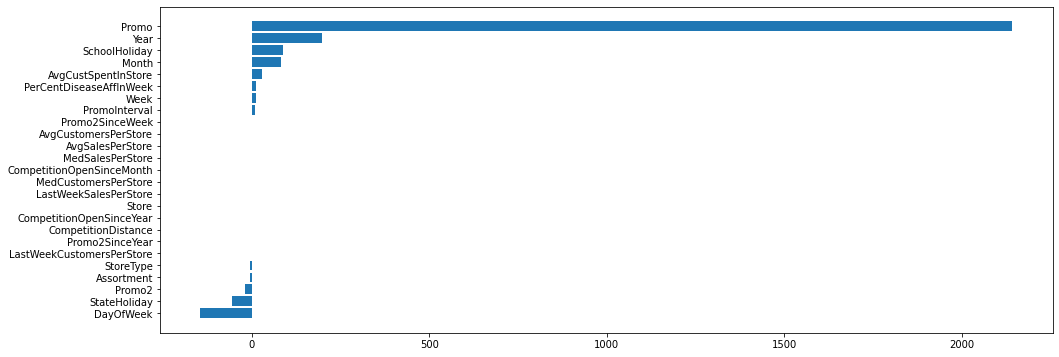

In [ ]:
cust_plot_importance(lr_regr, X_train, "linear_reg")

### Using Random Forest Regressor

In [ ]:
# Training a hyper-parameter tuned random forest regressor on our train data
# find more about LinearRegression function here 
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# -------------------------
# default paramters
# sklearn.ensemble.RandomForestRegressor(n_estimators=10, criterion=’mse’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)

# some of methods of RandomForestRegressor()
# apply(X)	Apply trees in the forest to X, return leaf indices.
# decision_path(X)	Return the decision path in the forest
# fit(X, y[, sample_weight])	Build a forest of trees from the training set (X, y).
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict regression target for X.
# score(X, y[, sample_weight])	Returns the coefficient of determination R^2 of the prediction.
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------
"""
{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}"""
#rf_regr = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=40, n_jobs=-1)
#rf_regr.fit(X_train, y_train)

In [ ]:
#Refer above cell for more about XGboost parameters.
start_time = time()
print("="*100)
print("Start Executing RandomForestRegressor with RandomSearchCV:")
rf_regr_est = RandomForestRegressor()
rf_parameters = {
    'n_estimators': [5, 10, 25, 50, 75, 100],
    'criterion': ['squared_error'], #{“squared_error”, “absolute_error”, “friedman_mse”, “poisson”}, default=”squared_error”
    'bootstrap': [True, False],
    'max_depth': [1,5,10,30,50],
    'max_features': ['auto', 'sqrt'], #{“sqrt”, “log2”, None}, int or float, default=1.0 e.g.,If “sqrt”, then max_features=sqrt(n_features)
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [5,10,100,500],
    #'random_state': 42
    }
rf_RandSearchCV_clf = RandomizedSearchCV(
                      estimator = rf_regr_est, 
                      param_distributions = rf_parameters, 
                      cv=3, 
                      return_train_score = True,
                      n_jobs = -1
                      )
rf_RandSearchCV_clf.fit(X_train, y_train)
rf_pred = rf_RandSearchCV_clf.predict(X_test)
rf_mse = metrics.mean_squared_error(y_test, rf_pred)
print("RandomForestRegr mean square error:   %0.3f" % rf_mse)

end_time = time() - start_time
print("Time Took: %0.3f sec"% end_time)
print("End of Execution")
print("="*100)

Start Executing RandomForestRegressor with RandomSearchCV:
RandomForestRegr mean square error:   690860.696
Time Took: 1019.827 sec
End of Execution


In [ ]:
print(rf_RandSearchCV_clf.best_params_)

{'n_estimators': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30, 'criterion': 'squared_error', 'bootstrap': True}


In [ ]:
rf_regr = RandomForestRegressor(
          n_estimators = 5,
          criterion = 'squared_error',
          bootstrap = True,
          max_features='auto',
          min_samples_leaf=2,
          min_samples_split=10,
          max_depth = 30,
          n_jobs=-1
          )
rf_regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, min_samples_leaf=2, min_samples_split=10,
                      n_estimators=5, n_jobs=-1)

In [ ]:
# Predicting on test data using our trained random forest model 

# the models regr1 is already hyper parameter tuned
# the parameters that we got above are found using grid search

y_rf_pred = rf_regr.predict(X_test)

In [ ]:
rmspe_rf = rmspe(y_test, y_rf_pred)
print("rmspe_rf: ",rmspe_rf)

rmspe_rf:  13.161535459256058


In [66]:
# Best Parameter with rmspe_score
rf_n_estimator=5
rf_max_depth=30
rf_lrn_rate="NA"
rf_rmspe_score=13.16

In [ ]:
y_rf_test_pred = rf_regr.predict(test_merge_store_df)

In [ ]:
y_rf_test_pred

array([ 4284.77638889,  7621.80757576,  8931.34423077, ...,
        5986.81916667, 21173.05121212,  8018.63039216])

Store percentile value is 0.005
DayOfWeek percentile value is 0.061
Promo percentile value is 0.154
StateHoliday percentile value is 0.001
SchoolHoliday percentile value is 0.005
StoreType percentile value is 0.005
Assortment percentile value is 0.002
CompetitionDistance percentile value is 0.008
CompetitionOpenSinceMonth percentile value is 0.003
CompetitionOpenSinceYear percentile value is 0.003
Promo2 percentile value is 0.0
Promo2SinceWeek percentile value is 0.002
Promo2SinceYear percentile value is 0.002
PromoInterval percentile value is 0.001
Year percentile value is 0.009
Month percentile value is 0.013
Week percentile value is 0.046
PerCentDiseaseAffInWeek percentile value is 0.016
AvgSalesPerStore percentile value is 0.555
AvgCustomersPerStore percentile value is 0.004
MedSalesPerStore percentile value is 0.077
MedCustomersPerStore percentile value is 0.005
AvgCustSpentInStore percentile value is 0.004
LastWeekSalesPerStore percentile value is 0.011
LastWeekCustomersPerStore 

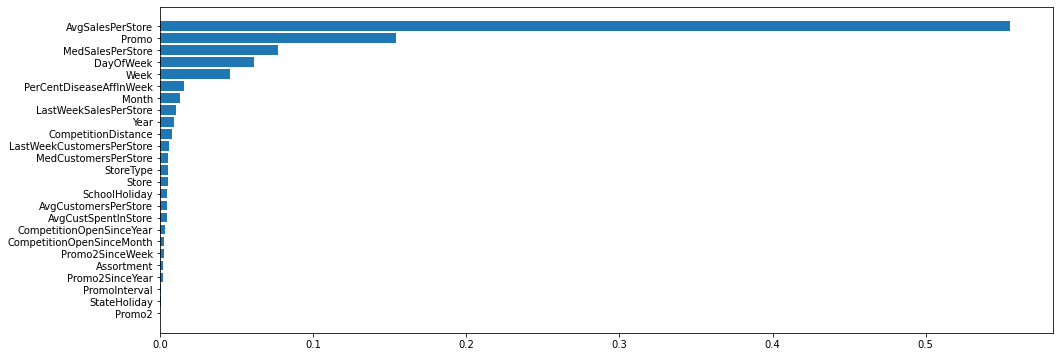

In [ ]:
cust_plot_importance(rf_regr, X_train, "rf_reg")

### Using XgBoost Regressor

In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBRegressor function here 
# http://xgboost.readthedocs.io/en/latest/python/python_api.html?#module-xgboost.sklearn
# [vishnu] https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters
# -------------------------
# default paramters
# xgboost.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', 
# booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, 
# colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, 
# missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link1: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/regression-using-decision-trees-2/
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

[08:46:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, min_child_weight=3, n_estimators=1000,
             nthread=4, reg_alpha=200, reg_lambda=200, subsample=0.8)

In [ ]:
start_time = time()
#Refer above cell for more about XGboost parameters.
print("="*100)
print("Start Executing XGBRegressor with RandomSearchCV:")
xgb_regr_est = XGBRegressor()
xgb_parameters = {
    'n_estimators': [5, 10, 25, 50, 75, 100],
    #'objective': ['binary:logistic']/'binary:logitraw'/'binary:hinge' for Binary Classification; multi:softprob for Multi-Class Classification; (for Loss Function)
    'objective': ['reg:squarederror'],
    #'eval_metric': ['rmse'], # Refer link in above cell, algorithm will take automatically based on problem type
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] ,
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6],
    'colsample_bytree': [0.4],
    'max_depth': [1,5,10,50]
    }
xgb_RandSearchCV_clf = RandomizedSearchCV(
                        estimator = xgb_regr_est, 
                        param_distributions = xgb_parameters, 
                        cv = 3, 
                        scoring = 'neg_mean_absolute_error',#with custom rmspe, train and cv score in cv_results are set as nan, we have to use make_scorer to call rmspe
                        return_train_score = True,
                        n_jobs = -1
                        )
xgb_RandSearchCV_clf.fit(X_train, y_train)
xgb_pred = xgb_RandSearchCV_clf.predict(X_test)
xgb_mse = metrics.mean_squared_error(y_test, xgb_pred)
print("mean square error:   %0.3f" % xgb_mse)

end_time = time() - start_time
print("Time Took: %0.3f sec"% end_time)
print("End of Execution")
print("="*100)

Start Executing XGBRegressor with RandomSearchCV:
mean square error:   572419.957
Time Took: 3364.972 sec
End of Execution


In [ ]:
print(xgb_RandSearchCV_clf.best_params_)

{'subsample': 0.6, 'objective': 'reg:squarederror', 'n_estimators': 75, 'min_child_weight': 1, 'max_depth': 50, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.4}


In [ ]:
xgb_regr = XGBRegressor(n_estimators=75, 
                        subsample=0.6, 
                        colsample_bytree=0.4, 
                        min_child_weight=1,
                        learning_rate=0.1, 
                        gamma=0.5, 
                        max_depth=50,
                        objective='reg:squarederror',
                        n_jobs=-1
                        )
xgb_regr.fit(X_train, y_train)# Train the regressor/Fit the model  
y_xgb_pred = xgb_regr.predict(X_test)

In [ ]:
rmspe_xgb = rmspe(y_test, y_xgb_pred)
print("rmspe_xgb: ",rmspe_xgb)

rmspe_xgb:  12.991040983664773


In [67]:
# Best Parameter with rmspe_score
xg_n_estimator=75
xg_max_depth=50
xg_lrn_rate=0.1
xg_rmspe_score=12.99

In [ ]:
y_xgb_test_pred = xgb_regr.predict(test_merge_store_df)

In [ ]:
y_xgb_test_pred

array([ 3884.4045,  7413.5815,  9386.421 , ...,  6287.3843, 21296.422 ,
        7303.7935], dtype=float32)

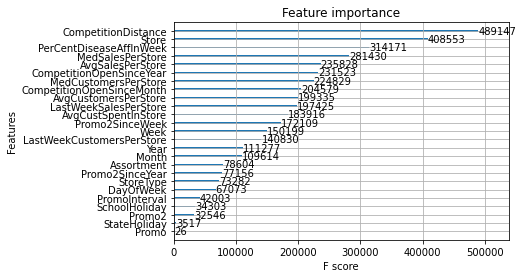

In [ ]:
xgb.plot_importance(xgb_regr)

In [103]:
from tabulate import tabulate
data = [['Model','Window','alpha','n_estimators','max_depth','learn_rate','RMSPE'],
        ["SMA", sma_window, "NA", "NA", "NA", "NA", sma_rmspe_score],
        ["WMA", wma_window, "NA", "NA", "NA", "NA", wma_rmspe_score],
        ["EWMA",ewma_window, ewma_alpha, "NA","NA","NA", ewma_rmspe_score],
        ["Linear Regr","NA", lr_alpha, lr_n_estimator,lr_max_depth,lr_lrn_rate,lr_rmspe_score],
        ["Random Forest Regr","NA", "NA", rf_n_estimator,rf_max_depth,rf_lrn_rate,rf_rmspe_score], 
        ["XGBoost Regr","NA", "NA", xg_n_estimator,xg_max_depth,xg_lrn_rate,xg_rmspe_score]] 
print(tabulate(data, headers='firstrow', showindex='always', tablefmt='fancy_grid'))


╒════╤════════════════════╤══════════╤═════════╤════════════════╤═════════════╤══════════════╤═════════╕
│    │ Model              │ Window   │ alpha   │ n_estimators   │ max_depth   │ learn_rate   │   RMSPE │
╞════╪════════════════════╪══════════╪═════════╪════════════════╪═════════════╪══════════════╪═════════╡
│  0 │ SMA                │ 50       │ NA      │ NA             │ NA          │ NA           │   51.68 │
├────┼────────────────────┼──────────┼─────────┼────────────────┼─────────────┼──────────────┼─────────┤
│  1 │ WMA                │ 50       │ NA      │ NA             │ NA          │ NA           │   51.96 │
├────┼────────────────────┼──────────┼─────────┼────────────────┼─────────────┼──────────────┼─────────┤
│  2 │ EWMA               │ 50       │ 0.4     │ NA             │ NA          │ NA           │   57.45 │
├────┼────────────────────┼──────────┼─────────┼────────────────┼─────────────┼──────────────┼─────────┤
│  3 │ Linear Regr        │ NA       │ 0.0008  │ NA    

# References

In [ ]:
# https://www.analyticsvidhya.com/blog/2021/04/rapid-fire-eda-process-using-python-for-ml-implementation/
# https://towardsdatascience.com/seaborn-heatmap-for-visualising-data-correlations-66cbef09c1fe
# https://towardsdatascience.com/how-to-use-pca-tsne-xgboost-and-finally-bayesian-optimization-to-predict-the-price-of-houses-626dbaf242ae
# https://medium.com/rapids-ai/tsne-with-gpus-hours-to-seconds-9d9c17c941db
# https://www.kaggle.com/code/anasmjali/dimensionality-reduction-pca-and-tsne
# https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/#:~:text=A%20one%20hot%20encoding%20is,is%20marked%20with%20a%201.
# https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
# https://machinelearningmastery.com/xgboost-loss-functions/
# https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/
# https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://stackoverflow.com/questions/53705966/sklearn-use-randomizedsearchcv-with-custom-metrics-and-catch-exceptions
# https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH04/CH04_exercises_solution.ipynb
# https://towardsdatascience.com/how-to-code-different-types-of-moving-averages-in-python-4f8ed6d2416f
# https://towardsdatascience.com/moving-averages-in-python-16170e20f6c
# https://www.geeksforgeeks.org/how-to-calculate-moving-averages-in-python/
# https://www.geeksforgeeks.org/how-to-decide-window-size-for-a-moving-average-filter-in-matlab/
# https://medium.com/data-folks-indonesia/simple-moving-average-sma-indicator-using-machine-learning-e8951f61dd9b